In [1]:
import pandas as pd
import numpy as np
import glob
import os
import ta # для технических индикаторов
from IPython.display import display # для красивого вывода DataFrame

# FinRL imports
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.agents.stablebaselines3.models import DRLAgent # (Убедитесь, что DRLAgent.DRL_prediction определен или есть альтернатива)
from finrl import config # для config.INDICATORS и других путей, если используются
# from finrl.config_tickers import DOW_30_TICKER # Пример, если используется

# Gymnasium (замена OpenAI Gym)
import gymnasium as gym
from gymnasium import spaces
from gymnasium.utils import seeding

# Stable Baselines3
from stable_baselines3 import SAC, A2C, PPO, DDPG # Импортируем нужные алгоритмы
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.noise import NormalActionNoise # для DDPG, SAC

# CatBoost
from catboost import CatBoostRegressor

# Другие полезные библиотеки
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split # Может понадобиться для CatBoost, хотя мы будем делать walk-forward
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Отключим лишние предупреждения (опционально)
import warnings
warnings.filterwarnings('ignore')

print("Все необходимые библиотеки импортированы.")

Все необходимые библиотеки импортированы.


In [2]:
# Путь к папке с данными
data_dir = "../data" # Убедитесь, что путь правильный

# Создаем пустой список для хранения данных
data_frames = []

# Изменяем шаблон поиска: только файлы вида <tic><pair>_hourly_data.csv
file_pattern = os.path.join(data_dir, "*_hourly_data.csv")
file_paths = glob.glob(file_pattern)

print(f"Найдено {len(file_paths)} файлов по шаблону: {file_pattern}")

if not file_paths:
    print("ВНИМАНИЕ: Ни одного файла не найдено. Проверьте путь 'data_dir' и шаблон 'file_pattern'.")
else:
    print("Найденные файлы:", file_paths[:5]) # Показываем первые 5 для примера

# Обрабатываем каждый подходящий файл
for file_path in file_paths:
    # Имя файла без пути
    file_name = os.path.basename(file_path)

    # Извлекаем тикер и пару (например, "APTUSDT" из "APTUSDT_hourly_data.csv")
    symbol = file_name.replace("_hourly_data.csv", "")

    try:
        # Читаем CSV-файл
        df_single_tic = pd.read_csv(file_path)

        # Очищаем имена столбцов
        df_single_tic.columns = df_single_tic.columns.str.strip().str.lower()

        # Переименовываем столбцы (если они еще не 'date', 'open', 'high', 'low', 'close', 'volume')
        rename_map = {
            "open time": "date",
            "open": "open",
            "high": "high",
            "low": "low",
            "close": "close",
            "volume": "volume"
        }
        # Применяем переименование только к существующим колонкам
        df_single_tic.rename(columns={k: v for k, v in rename_map.items() if k in df_single_tic.columns}, inplace=True)


        # Добавляем столбец tic
        df_single_tic["tic"] = symbol

        # Проверяем наличие необходимых столбцов
        required_columns = ["date", "open", "high", "low", "close", "volume", "tic"]
        missing_cols = [col for col in required_columns if col not in df_single_tic.columns]
        
        if not missing_cols:
            df_single_tic = df_single_tic[required_columns] # Выбираем и упорядочиваем
            data_frames.append(df_single_tic)
        else:
            print(f"В файле {file_path} отсутствуют необходимые столбцы: {missing_cols}.")
            print("  Доступные столбцы:", df_single_tic.columns.tolist())
            continue

    except Exception as e:
        print(f"Ошибка при обработке файла {file_path}: {e}")

# Объединяем все DataFrame в один
if data_frames:
    final_df = pd.concat(data_frames, ignore_index=True)

    # Преобразуем столбец date в datetime (важно!)
    final_df["date"] = pd.to_datetime(final_df["date"])

    # Сортируем данные по тикеру и дате, это важно для последующих шагов
    final_df.sort_values(by=['tic', 'date'], inplace=True)
    final_df.reset_index(drop=True, inplace=True)

    print("\nИтоговый DataFrame (первые строки):")
    display(final_df.head())
    print("\nИтоговый DataFrame (последние строки):")
    display(final_df.tail())
    print("\nРазмер итогового DataFrame:", final_df.shape)
    print("\nУникальные тикеры в DataFrame:", final_df['tic'].unique())
    print("\nИнформация о типах данных:")
    final_df.info()
else:
    print("\nНет подходящих данных для объединения. Дальнейшее выполнение скрипта может быть невозможно.")
    final_df = pd.DataFrame() # Создаем пустой DataFrame, чтобы избежать ошибок ниже, но это проблема

Найдено 15 файлов по шаблону: ../data\*_hourly_data.csv
Найденные файлы: ['../data\\APTUSDT_hourly_data.csv', '../data\\BNBUSDT_hourly_data.csv', '../data\\BTCUSDT_hourly_data.csv', '../data\\CAKEUSDT_hourly_data.csv', '../data\\ETHUSDT_hourly_data.csv']

Итоговый DataFrame (первые строки):


,date,open,high,low,close,volume,tic
0,2022-10-19 01:00:00,1.0000,100.0000,1.0000,8.4946,14808472.50,APTUSDT
1,2022-10-19 02:00:00,8.5077,8.5895,6.9170,7.4817,6936252.07,APTUSDT
2,2022-10-19 03:00:00,7.4817,7.6000,6.6000,6.8147,3917949.82,APTUSDT
3,2022-10-19 04:00:00,6.8038,7.5300,6.7456,7.1741,3598717.51,APTUSDT
4,2022-10-19 05:00:00,7.1806,8.2500,7.1770,7.9068,5028746.51,APTUSDT



Итоговый DataFrame (последние строки):


,date,open,high,low,close,volume,tic
433015,2025-05-10 01:00:00,2.3408,2.3630,2.3402,2.3496,3489883.2,XRPUSDT
433016,2025-05-10 02:00:00,2.3497,2.3799,2.3450,2.3719,5886758.6,XRPUSDT
433017,2025-05-10 03:00:00,2.3719,2.3746,2.3590,2.3672,2562157.3,XRPUSDT
433018,2025-05-10 04:00:00,2.3672,2.3673,2.3500,2.3656,3541767.0,XRPUSDT
433019,2025-05-10 05:00:00,2.3656,2.3673,2.3526,2.3588,1584035.7,XRPUSDT



Размер итогового DataFrame: (433020, 7)

Уникальные тикеры в DataFrame: ['APTUSDT' 'BNBUSDT' 'BTCUSDT' 'CAKEUSDT' 'ETHUSDT' 'HBARUSDT' 'JUPUSDT'
 'LDOUSDT' 'LTCUSDT' 'PEPEUSDT' 'SOLUSDT' 'STRKUSDT' 'TONUSDT' 'USDCUSDT'
 'XRPUSDT']

Информация о типах данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 433020 entries, 0 to 433019
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    433020 non-null  datetime64[ns]
 1   open    433020 non-null  float64       
 2   high    433020 non-null  float64       
 3   low     433020 non-null  float64       
 4   close   433020 non-null  float64       
 5   volume  433020 non-null  float64       
 6   tic     433020 non-null  object        
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 23.1+ MB


In [3]:
if not final_df.empty:
    # 1. Выборка тикеров (если нужно ограничить)
    # Если вы хотите работать со всеми тикерами, которые загрузились, эту строку можно закомментировать.
    # Если хотите выбрать конкретные, раскомментируйте и укажите свой список.
    # symbols_to_use = ['BTCUSDT', 'PEPEUSDT', 'APTUSDT', 'CAKEUSDT', 'HBARUSDT', 'STRKUSDT', 'USDCUSDT']
    # df_prep = final_df[final_df['tic'].isin(symbols_to_use)].copy()
    
    # Работаем со всеми загруженными тикерами
    df_prep = final_df.copy()
    print(f"Работаем с {len(df_prep['tic'].unique())} тикерами: {df_prep['tic'].unique().tolist()}")


    # 2. Выравнивание данных по максимальной начальной дате
    # Это гарантирует, что у всех тикеров есть данные, начиная с одной и той же точки.
    min_dates_per_tic = df_prep.groupby('tic')['date'].min()
    max_start_date = min_dates_per_tic.max()

    df_prep_aligned = df_prep[df_prep['date'] >= max_start_date].copy()

    print(f"\nДанные выровнены. Единая начальная дата для всех тикеров: {max_start_date}")
    
    # Проверка, что у всех тикеров теперь одинаковая минимальная дата
    # (может быть небольшое расхождение из-за дискретности времени, но они должны быть очень близки)
    print("\nМинимальные даты по тикерам после выравнивания:")
    print(df_prep_aligned.groupby('tic')['date'].min())
    
    # Проверка на количество уникальных дат для каждого тикера
    date_counts_per_tic = df_prep_aligned.groupby('tic')['date'].nunique()
    if date_counts_per_tic.nunique() > 1:
        print("\nПРЕДУПРЕЖДЕНИЕ: Количество уникальных дат РАЗЛИЧАЕТСЯ для тикеров после выравнивания!")
        print(date_counts_per_tic)
        print("Это может вызвать проблемы при расчете индикаторов или ковариаций.")
        print("Возможные причины: пропуски данных в некоторых файлах, разная частота.")
    else:
        print(f"\nВсе тикеры имеют одинаковое количество ({date_counts_per_tic.iloc[0]}) временных точек после выравнивания.")

    print(f"\nРазмер DataFrame после выравнивания: {df_prep_aligned.shape}")
    
    # 3. Добавление технических индикаторов
    # Убедимся, что дата отсортирована внутри каждой группы тикеров
    df_prep_aligned = df_prep_aligned.sort_values(by=['tic', 'date']).reset_index(drop=True)

    # Функция для добавления индикаторов к группе по tic
    def add_technical_features_for_group(group):
        # Добавляем все доступные индикаторы через ta
        # fillna=True - заполняет NaN, возникающие в начале расчета индикаторов
        group = ta.add_all_ta_features(
            group,
            open="open",
            high="high",
            low="low",
            close="close",
            volume="volume",
            fillna=True # ВАЖНО: заполняем NaN, чтобы не терять строки
        )
        return group

    print("\nДобавление технических индикаторов...")
    # Применяем к каждому тикеру отдельно
    # group_keys=False чтобы избежать лишнего MultiIndex при выводе
    df_with_ta = df_prep_aligned.groupby("tic", group_keys=False).apply(add_technical_features_for_group)
    
    # Вручную добавляем SMA, которые могут быть не покрыты add_all_ta_features
    # или если нужны конкретные периоды
    df_with_ta['close_15_sma'] = df_with_ta.groupby('tic')['close'].transform(lambda x: x.rolling(window=15).mean())
    df_with_ta['close_30_sma'] = df_with_ta.groupby('tic')['close'].transform(lambda x: x.rolling(window=30).mean())
    df_with_ta['close_60_sma'] = df_with_ta.groupby('tic')['close'].transform(lambda x: x.rolling(window=60).mean())
    
    # После rolling mean снова появляются NaN в начале, заполним их методом bfill (обратное заполнение)
    # внутри каждой группы тикеров
    for col in ['close_15_sma', 'close_30_sma', 'close_60_sma']:
        df_with_ta[col] = df_with_ta.groupby('tic', group_keys=False)[col].bfill()

    # Переименование некоторых индикаторов для удобства (опционально, но полезно для FinRL)
    # Словарь: исходное имя → новое имя (удобное для RL)
    indicator_mapping = {
        'trend_macd': 'macd',
        'trend_macd_signal': 'macd_signal',
        'trend_macd_diff': 'macd_diff',
        'volatility_bbh': 'boll_ub', # Bollinger Bands High
        'volatility_bbl': 'boll_lb', # Bollinger Bands Low
        'volatility_bbm': 'boll_mb', # Bollinger Bands Middle
        'momentum_rsi': 'rsi',       # RSI (обычно RSI_14 по умолчанию в ta)
        'trend_cci': 'cci',          # CCI (обычно CCI_20)
        'trend_adx': 'adx',          # ADX (обычно ADX_14)
        # Можно добавить другие, если они используются в config.INDICATORS или нужны DRL
    }
    
    # Проверяем, какие колонки действительно есть в данных
    available_columns = df_with_ta.columns.tolist()
    valid_mapping = {src: dst for src, dst in indicator_mapping.items() if src in available_columns}
    df_with_ta.rename(columns=valid_mapping, inplace=True)
    
    print("\nТехнические индикаторы добавлены и переименованы.")
    print("Размер DataFrame с ТА-индикаторами:", df_with_ta.shape)
    print("\nПример данных с ТА-индикаторами (первые строки):")
    display(df_with_ta.head())
    
    # Проверка на NaN после добавления всех индикаторов
    nan_counts_ta = df_with_ta.isnull().sum()
    print("\nКоличество NaN в столбцах после добавления ТА:")
    print(nan_counts_ta[nan_counts_ta > 0])
    if nan_counts_ta.sum() == 0:
        print("Отлично! В DataFrame нет NaN после добавления и обработки ТА-индикаторов.")
    else:
        print(f"ПРЕДУПРЕЖДЕНИЕ: Обнаружено {nan_counts_ta.sum()} NaN значений. "
              "Это может произойти, если bfill не смог заполнить все для SMA (мало данных в группе). "
              "Рассмотрите возможность их дополнительной обработки или удаления строк/тикеров.")
        # Можно принудительно заполнить оставшиеся NaN нулями, но это может исказить данные
        # df_with_ta.fillna(0, inplace=True)
        # print("Все оставшиеся NaN были заполнены нулями.")


else:
    print("Переменная 'final_df' пуста. Пропуск шага добавления ТА-индикаторов.")
    df_with_ta = pd.DataFrame()

Работаем с 15 тикерами: ['APTUSDT', 'BNBUSDT', 'BTCUSDT', 'CAKEUSDT', 'ETHUSDT', 'HBARUSDT', 'JUPUSDT', 'LDOUSDT', 'LTCUSDT', 'PEPEUSDT', 'SOLUSDT', 'STRKUSDT', 'TONUSDT', 'USDCUSDT', 'XRPUSDT']

Данные выровнены. Единая начальная дата для всех тикеров: 2024-08-08 10:00:00

Минимальные даты по тикерам после выравнивания:
tic
APTUSDT    2024-08-08 10:00:00
BNBUSDT    2024-08-08 10:00:00
BTCUSDT    2024-08-08 10:00:00
CAKEUSDT   2024-08-08 10:00:00
ETHUSDT    2024-08-08 10:00:00
HBARUSDT   2024-08-08 10:00:00
JUPUSDT    2024-08-08 10:00:00
LDOUSDT    2024-08-08 10:00:00
LTCUSDT    2024-08-08 10:00:00
PEPEUSDT   2024-08-08 10:00:00
SOLUSDT    2024-08-08 10:00:00
STRKUSDT   2024-08-08 10:00:00
TONUSDT    2024-08-08 10:00:00
USDCUSDT   2024-08-08 10:00:00
XRPUSDT    2024-08-08 10:00:00
Name: date, dtype: datetime64[ns]

Все тикеры имеют одинаковое количество (6596) временных точек после выравнивания.

Размер DataFrame после выравнивания: (98955, 7)

Добавление технических индикаторов...

Те

,date,open,high,low,close,volume,tic,volume_adi,volume_obv,volume_cmf,...,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr,close_15_sma,close_30_sma,close_60_sma
0,2024-08-08 10:00:00,5.29,5.32,5.27,5.30,41736.54,APTUSDT,8347.308000,41736.54,0.200000,...,0.000000,0.000000,0.000000,5.300000,-32.716528,0.000000,0.000000,5.495333,5.616667,5.766
1,2024-08-08 11:00:00,5.30,5.32,5.28,5.29,50721.38,APTUSDT,-17013.382000,-8984.84,-0.184012,...,1.690340,0.338068,1.352272,5.297926,-0.188679,-0.188857,-0.188679,5.495333,5.616667,5.766
2,2024-08-08 12:00:00,5.29,5.41,5.26,5.34,143097.82,APTUSDT,-7473.527333,134112.98,-0.031727,...,17.326518,3.735758,13.590760,5.301384,0.945180,0.940741,0.754717,5.495333,5.616667,5.766
3,2024-08-08 13:00:00,5.35,5.38,5.25,5.30,106390.56,APTUSDT,-32025.195026,27722.42,-0.093656,...,21.868462,7.362299,14.506163,5.301114,-0.749064,-0.751883,0.000000,5.495333,5.616667,5.766
4,2024-08-08 14:00:00,5.30,5.45,5.30,5.45,120665.28,APTUSDT,88640.084974,148387.70,0.191608,...,25.965672,11.082974,14.882698,5.305096,2.830189,2.790879,2.830189,5.495333,5.616667,5.766



Количество NaN в столбцах после добавления ТА:
Series([], dtype: int64)
Отлично! В DataFrame нет NaN после добавления и обработки ТА-индикаторов.


In [4]:
if not df_with_ta.empty:
    from catboost import CatBoostRegressor

    # --- Параметры для CatBoost ---
    CATBOOST_PREDICTION_HORIZON_DAYS = 8
    CATBOOST_PREDICTION_HORIZON_HOURS = CATBOOST_PREDICTION_HORIZON_DAYS * 24
    
    CATBOOST_LAGS_HOURS = [1, 2, 3, 6, 12, 
                           24-1, 24, 24+1, 
                           48-1, 48, 48+1, 
                           CATBOOST_PREDICTION_HORIZON_HOURS - 24, 
                           CATBOOST_PREDICTION_HORIZON_HOURS,      
                           CATBOOST_PREDICTION_HORIZON_HOURS + 24]
    CATBOOST_LAGS_HOURS = sorted(list(set(l for l in CATBOOST_LAGS_HOURS if l > 0)))

    CATBOOST_MODEL_PARAMS = {
        'n_estimators': 150,      
        'learning_rate': 0.05,    
        'depth': 6,               
        'random_state': 42,
        'logging_level': 'Silent',
        'loss_function': 'RMSE',  
        'eval_metric': 'RMSE'
    }
    
    print(f"\n--- Начало генерации предсказаний CatBoost ---")
    print(f"Горизонт предсказания CatBoost: {CATBOOST_PREDICTION_HORIZON_DAYS} дней ({CATBOOST_PREDICTION_HORIZON_HOURS} часов)")
    print(f"Используемые лаги для CatBoost (часы): {CATBOOST_LAGS_HOURS}")

    df_with_catboost_preds = df_with_ta.copy()
    df_with_catboost_preds['catboost_prediction'] = np.nan

    unique_tickers_for_cb = df_with_catboost_preds['tic'].unique()

    for tic_symbol in unique_tickers_for_cb:
        print(f"  Обработка тикера для CatBoost: {tic_symbol}")
        
        df_tic_cb = df_with_catboost_preds[df_with_catboost_preds['tic'] == tic_symbol].copy()
        df_tic_cb.sort_values(by='date', inplace=True)

        df_tic_cb['catboost_target'] = df_tic_cb['close'].shift(-CATBOOST_PREDICTION_HORIZON_HOURS)

        for lag_h in CATBOOST_LAGS_HOURS:
            df_tic_cb[f'cb_lag_close_{lag_h}h'] = df_tic_cb['close'].shift(lag_h)
        
        df_tic_cb['cb_hour'] = df_tic_cb['date'].dt.hour
        df_tic_cb['cb_dayofweek'] = df_tic_cb['date'].dt.dayofweek
        df_tic_cb['cb_price_change_pct_1h'] = df_tic_cb['close'].pct_change(periods=1) * 100
        df_tic_cb['cb_price_change_pct_24h'] = df_tic_cb['close'].pct_change(periods=24) * 100

        catboost_feature_columns = [col for col in df_tic_cb.columns if col.startswith('cb_')]
        
        cols_to_check_for_nan = ['catboost_target'] + catboost_feature_columns
        df_tic_cb.dropna(subset=cols_to_check_for_nan, inplace=True)

        if df_tic_cb.empty or len(df_tic_cb) < (max(CATBOOST_LAGS_HOURS) + 50): 
            print(f"    Недостаточно данных для обучения CatBoost для {tic_symbol} (после dropna: {len(df_tic_cb)}). Пропуск.")
            continue

        X_cb = df_tic_cb[catboost_feature_columns]
        y_cb = df_tic_cb['catboost_target']

        cb_model = CatBoostRegressor(**CATBOOST_MODEL_PARAMS)
        try:
            cb_model.fit(X_cb, y_cb)
            predictions_for_tic = cb_model.predict(X_cb)
            df_with_catboost_preds.loc[df_tic_cb.index, 'catboost_prediction'] = predictions_for_tic
            print(f"    CatBoost для {tic_symbol} обучен. Сделано {len(predictions_for_tic)} предсказаний.")
        except Exception as e:
            print(f"    Ошибка при обучении/предсказании CatBoost для {tic_symbol}: {e}")

    df_with_catboost_preds['catboost_prediction'] = \
        df_with_catboost_preds.groupby('tic', group_keys=False)['catboost_prediction'].apply(lambda x: x.ffill().bfill())
    
    nan_preds_by_tic = df_with_catboost_preds.groupby('tic')['catboost_prediction'].apply(lambda x: x.isnull().all())
    tics_with_all_nan_preds = nan_preds_by_tic[nan_preds_by_tic].index.tolist()
    if tics_with_all_nan_preds:
        print(f"ПРЕДУПРЕЖДЕНИЕ: Для следующих тикеров все предсказания CatBoost являются NaN (недостаточно данных): {tics_with_all_nan_preds}")
        print("  Эти NaN будут заполнены нулями. Это может повлиять на DRL.")
    df_with_catboost_preds['catboost_prediction'].fillna(0, inplace=True)
    
    print("\nПредсказания CatBoost добавлены и NaN обработаны.")
    print("Пример данных с предсказаниями CatBoost (первые строки):")
    # ИЗМЕНЕНИЕ ЗДЕСЬ: Убрали 'catboost_target' из display
    display(df_with_catboost_preds[['date', 'tic', 'close', 'catboost_prediction']].head()) 
    
    if df_with_catboost_preds['catboost_prediction'].isnull().any():
        print("КРИТИЧЕСКОЕ ПРЕДУПРЕЖДЕНИЕ: NaN все еще присутствуют в 'catboost_prediction'!")
    else:
        print("Финальная проверка: NaN в 'catboost_prediction' отсутствуют.")
        
    df_processed = df_with_catboost_preds.copy()
    # Колонка 'catboost_target' и так не должна быть в df_processed (бывшая df_with_catboost_preds)
    # Но на всякий случай, если логика где-то изменилась, оставим удаление с проверкой
    if 'catboost_target' in df_processed.columns:
        df_processed.drop(columns=['catboost_target'], inplace=True, errors='ignore')

else:
    print("Переменная 'df_with_ta' пуста. Пропуск шага добавления предсказаний CatBoost.")
    df_processed = pd.DataFrame()


--- Начало генерации предсказаний CatBoost ---
Горизонт предсказания CatBoost: 8 дней (192 часов)
Используемые лаги для CatBoost (часы): [1, 2, 3, 6, 12, 23, 24, 25, 47, 48, 49, 168, 192, 216]
  Обработка тикера для CatBoost: APTUSDT
    CatBoost для APTUSDT обучен. Сделано 6189 предсказаний.
  Обработка тикера для CatBoost: BNBUSDT
    CatBoost для BNBUSDT обучен. Сделано 6189 предсказаний.
  Обработка тикера для CatBoost: BTCUSDT
    CatBoost для BTCUSDT обучен. Сделано 6189 предсказаний.
  Обработка тикера для CatBoost: CAKEUSDT
    CatBoost для CAKEUSDT обучен. Сделано 6189 предсказаний.
  Обработка тикера для CatBoost: ETHUSDT
    CatBoost для ETHUSDT обучен. Сделано 6189 предсказаний.
  Обработка тикера для CatBoost: HBARUSDT
    CatBoost для HBARUSDT обучен. Сделано 6189 предсказаний.
  Обработка тикера для CatBoost: JUPUSDT
    CatBoost для JUPUSDT обучен. Сделано 6189 предсказаний.
  Обработка тикера для CatBoost: LDOUSDT
    CatBoost для LDOUSDT обучен. Сделано 6189 предсказ

,date,tic,close,catboost_prediction
0,2024-08-08 10:00:00,APTUSDT,5.30,6.309808
1,2024-08-08 11:00:00,APTUSDT,5.29,6.309808
2,2024-08-08 12:00:00,APTUSDT,5.34,6.309808
3,2024-08-08 13:00:00,APTUSDT,5.30,6.309808
4,2024-08-08 14:00:00,APTUSDT,5.45,6.309808


Финальная проверка: NaN в 'catboost_prediction' отсутствуют.


In [5]:
if not df_processed.empty:
    print("\n--- Добавление ковариационных матриц и логарифмической доходности ---")
    
    df_for_cov = df_processed.sort_values(['date', 'tic']).copy()
    df_for_cov.reset_index(drop=True, inplace=True)

    # Создаем временный индекс на основе уникальных дат для корректной работы loc
    df_for_cov_indexed_by_date_factor = df_for_cov.copy()
    # Сохраним оригинальные date и tic как колонки, чтобы не было конфликта
    # при создании MultiIndex, если они уже там как-то используются.
    # Но для MultiIndex.from_arrays они должны быть массивами, а не частью существующего индекса.
    
    date_factors_arr, _ = df_for_cov_indexed_by_date_factor['date'].factorize()
    tic_arr = df_for_cov_indexed_by_date_factor['tic'].values # Берем как numpy массив
    
    df_for_cov_indexed_by_date_factor.index = pd.MultiIndex.from_arrays(
        [date_factors_arr, tic_arr], # Используем массивы
        names=['date_idx_level', 'tic_idx_level'] # Даем уникальные имена уровням индекса
    )

    cov_list = []
    LOOKBACK_WINDOW_HOURS = 24 * 7 
    min_len_tic_after_align = df_for_cov.groupby('tic').size().min()
    if LOOKBACK_WINDOW_HOURS >= min_len_tic_after_align:
        print(f"ПРЕДУПРЕЖДЕНИЕ: LOOKBACK_WINDOW_HOURS ({LOOKBACK_WINDOW_HOURS}) >= минимальной длины данных для тикера ({min_len_tic_after_align}).")
        LOOKBACK_WINDOW_HOURS = max(1, min_len_tic_after_align - 1) 
        print(f"  LOOKBACK_WINDOW_HOURS автоматически уменьшен до: {LOOKBACK_WINDOW_HOURS}")
    print(f"Окно для расчета ковариации: {LOOKBACK_WINDOW_HOURS} часов.")

    unique_date_factors = sorted(df_for_cov_indexed_by_date_factor.index.get_level_values('date_idx_level').unique())

    for i in range(LOOKBACK_WINDOW_HOURS -1, len(unique_date_factors)):
        current_lookback_start_factor = unique_date_factors[i - (LOOKBACK_WINDOW_HOURS - 1)]
        current_lookback_end_factor = unique_date_factors[i]
        
        # data_lookback теперь будет иметь MultiIndex ('date_idx_level', 'tic_idx_level')
        # и колонки 'date', 'tic', 'close', etc.
        data_lookback = df_for_cov_indexed_by_date_factor.loc[
            (slice(current_lookback_start_factor, current_lookback_end_factor), slice(None)), :
        ] # reset_index() пока не делаем здесь

        # Для pivot_table нам нужны колонки 'date', 'tic', 'close'
        # Они уже есть в data_lookback
        price_lookback_pivot = data_lookback.pivot_table(index='date', columns='tic', values='close')
        
        return_lookback_pct = price_lookback_pivot.pct_change().dropna()
        cov_matrix = return_lookback_pct.cov().values 
        cov_list.append(cov_matrix)

    # --- Остальная часть кода без изменений ---
    # Создаем DataFrame с ковариационными матрицами
    date_factors_with_cov = unique_date_factors[LOOKBACK_WINDOW_HOURS-1:]
    
    # Создаем отображение из date_factor в date, используя оригинальную колонку 'date' и ее факторы
    date_factor_to_date_map_df = df_for_cov[['date']].copy()
    date_factor_to_date_map_df['date_factor_col'], _ = df_for_cov['date'].factorize()
    date_factor_to_date_map_df = date_factor_to_date_map_df.drop_duplicates(subset=['date_factor_col'])
    date_factor_to_date_map = date_factor_to_date_map_df.set_index('date_factor_col')['date']
    
    dates_for_cov_df = [date_factor_to_date_map[factor] for factor in date_factors_with_cov]

    if len(dates_for_cov_df) != len(cov_list):
        print("КРИТИЧЕСКАЯ ОШИБКА: Длина списка дат не совпадает с длиной списка ковариаций!")
        
    df_cov = pd.DataFrame({'date': dates_for_cov_df, 'cov_list': cov_list})
    df_final_with_all_features = pd.merge(df_processed, df_cov, on='date', how='left')
    df_final_with_all_features.dropna(subset=['cov_list'], inplace=True)
    df_final_with_all_features = df_final_with_all_features.sort_values(['date', 'tic']).reset_index(drop=True)
    
    print("\nКовариационные матрицы добавлены.")
    print("Размер DataFrame со всеми признаками:", df_final_with_all_features.shape)
    print("\nПример данных с ковариационными матрицами (первые строки):")
    display(df_final_with_all_features[['date', 'tic', 'close', 'catboost_prediction', 'cov_list']].head())

    if not df_final_with_all_features.empty and 'cov_list' in df_final_with_all_features.columns and \
       df_final_with_all_features['cov_list'].iloc[0] is not None:
        num_tickers = len(df_final_with_all_features['tic'].unique())
        expected_shape = (num_tickers, num_tickers)
        try: # Добавляем try-except на случай, если первая cov_list все еще None
            actual_shape = df_final_with_all_features['cov_list'].dropna().iloc[0].shape
            if actual_shape == expected_shape:
                print(f"Форма ковариационной матрицы ({actual_shape}) соответствует ожидаемой ({expected_shape}).")
            else:
                print(f"ПРЕДУПРЕЖДЕНИЕ: Форма ковариационной матрицы ({actual_shape}) НЕ соответствует ожидаемой ({expected_shape}).")
        except IndexError:
             print("Не удалось проверить форму ковариационной матрицы: нет не-NaN значений в 'cov_list'.")

    df_processed = df_final_with_all_features.copy()

    # Заменяем df_processed на финальный DataFrame
    df_processed = df_final_with_all_features.copy()

    # <<<< НАЧАЛО НОВОГО БЛОКА >>>>
    print(f"\nФинальная очистка df_processed от дубликатов (date, tic)...")
    initial_len_df_proc = len(df_processed)
    # Сортируем перед удалением дубликатов, чтобы keep='first' был предсказуем,
    # хотя если данные полностью идентичны, порядок не важен.
    # Если есть небольшие различия в других колонках, нужно решить, какую строку оставить.
    # Здесь мы предполагаем, что если (date, tic) дублируются, то одна из строк лишняя.
    df_processed.sort_values(by=['date', 'tic', 'close'], inplace=True) # Добавил 'close' для стабильности, если другие поля могут чуть отличаться
    df_processed.drop_duplicates(subset=['date', 'tic'], keep='first', inplace=True)
    if len(df_processed) < initial_len_df_proc:
        print(f"  Удалено {initial_len_df_proc - len(df_processed)} дубликатов по (date, tic) из df_processed.")
    df_processed.reset_index(drop=True, inplace=True)
    # <<<< КОНЕЦ НОВОГО БЛОКА >>>>

else:
    print("Переменная 'df_processed' пуста (вероятно, из-за ошибок на предыдущих шагах). Пропуск добавления ковариаций.")
    # df_processed остается пустым DataFrame



# Пример проверки после Ячейки 5 (добавление ковариаций)
print(f"\nПроверка df_processed на дубликаты (date, tic) ПОСЛЕ ковариаций:")
duplicates_df_proc = df_processed[df_processed.duplicated(subset=['date', 'tic'], keep=False)]
if not duplicates_df_proc.empty:
    print(f"  ОБНАРУЖЕНЫ ДУБЛИКАТЫ в df_processed: {len(duplicates_df_proc)} строк")
    display(duplicates_df_proc.sort_values(by=['date', 'tic']).head(10)) # Показываем первые 10 отсортированных дубликатов
else:
    print("  Дубликатов (date, tic) в df_processed не найдено.")


--- Добавление ковариационных матриц и логарифмической доходности ---
Окно для расчета ковариации: 168 часов.

Ковариационные матрицы добавлены.
Размер DataFrame со всеми признаками: (96450, 98)

Пример данных с ковариационными матрицами (первые строки):


,date,tic,close,catboost_prediction,cov_list
0,2024-08-15 09:00:00,APTUSDT,6.480,6.309808,"[[0.00013415814573033112, 4.0621234745684496e-..."
1,2024-08-15 09:00:00,BNBUSDT,520.100,570.171412,"[[0.00013415814573033112, 4.0621234745684496e-..."
2,2024-08-15 09:00:00,BTCUSDT,58412.640,60511.409996,"[[0.00013415814573033112, 4.0621234745684496e-..."
3,2024-08-15 09:00:00,CAKEUSDT,1.587,1.920474,"[[0.00013415814573033112, 4.0621234745684496e-..."
4,2024-08-15 09:00:00,ETHUSDT,2623.220,2594.322511,"[[0.00013415814573033112, 4.0621234745684496e-..."


Форма ковариационной матрицы ((15, 15)) соответствует ожидаемой ((15, 15)).

Финальная очистка df_processed от дубликатов (date, tic)...
  Удалено 15 дубликатов по (date, tic) из df_processed.

Проверка df_processed на дубликаты (date, tic) ПОСЛЕ ковариаций:
  Дубликатов (date, tic) в df_processed не найдено.


In [7]:
if not df_processed.empty:
    print("\n--- Разделение данных на Train/Test и определение параметров среды DRL ---")

    # 1. Определяем границы для обучающей и тестовой выборок
    unique_dates_in_df = df_processed['date'].unique()
    unique_dates_in_df = np.sort(unique_dates_in_df) # <--- ИЗМЕНЕНИЕ ЗДЕСЬ

    if len(unique_dates_in_df) < 2: 
        print("КРИТИЧЕСКАЯ ОШИБКА: Недостаточно уникальных дат в df_processed для разделения на train/test.")
        train_df = pd.DataFrame()
        test_df = pd.DataFrame()
    else:
        # Дата окончания обучающей выборки (80% данных по времени)
        # np.quantile ожидает массив или список, а не DatetimeIndex напрямую для некоторых версий.
        # Конвертация в int64 для квантиля и обратно в Timestamp
        numeric_unique_dates = pd.Series(unique_dates_in_df).astype(np.int64)
        end_train_numeric = np.quantile(numeric_unique_dates, 0.8)
        end_train_timestamp = pd.to_datetime(int(end_train_numeric)) # int() для случая если np.quantile вернул float

        possible_end_train_dates = unique_dates_in_df[unique_dates_in_df <= end_train_timestamp]
        if len(possible_end_train_dates) > 0:
            end_train_date = possible_end_train_dates[-1]
        else: 
            end_train_date = unique_dates_in_df[0]
            print(f"ПРЕДУПРЕЖДЕНИЕ: Не удалось найти дату для конца трейна <= {end_train_timestamp}. Используется {end_train_date}.")

        start_train_date = df_processed['date'].min()
        
        possible_start_test_dates = unique_dates_in_df[unique_dates_in_df > end_train_date]
        if len(possible_start_test_dates) > 0:
            start_test_date = possible_start_test_dates[0]
        else: 
            start_test_date = end_train_date + pd.Timedelta(hours=1) 
            print("ПРЕДУПРЕЖДЕНИЕ: Нет дат для тестовой выборки после конца обучающей. Тест будет пустым.")

        end_test_date = df_processed['date'].max()

        print(f"Границы обучающей выборки: {start_train_date} - {end_train_date}")
        print(f"Границы тестовой выборки:   {start_test_date} - {end_test_date}")
        
        # Используем прямое срезание DataFrame, так как data_split может иметь свою логику для < end_date
        train_df = df_processed[(df_processed['date'] >= start_train_date) & (df_processed['date'] <= end_train_date)].copy()
        test_df = df_processed[(df_processed['date'] >= start_test_date) & (df_processed['date'] <= end_test_date)].copy()
        
        # Если вы хотите использовать data_split, убедитесь в его поведении:
        # train_df = data_split(df_processed, start_train_date, start_test_date) 
        # test_df = data_split(df_processed, start_test_date, end_test_date + pd.Timedelta(hours=1))


        print(f"\nРазмер обучающей выборки (train_df): {train_df.shape}")
        if not train_df.empty:
            print(f"  Даты в train_df: с {train_df['date'].min()} по {train_df['date'].max()}")
        
        print(f"Размер тестовой выборки (test_df): {test_df.shape}")
        if not test_df.empty:
            print(f"  Даты в test_df: с {test_df['date'].min()} по {test_df['date'].max()}")

    # В Ячейке 6, после создания test_df:
if not test_df.empty:
    print("\nПроверка test_df на дубликаты (date, tic)...")
    duplicates_test = test_df[test_df.duplicated(subset=['date', 'tic'], keep=False)]
    if not duplicates_test.empty:
        print(f"ОБНАРУЖЕНЫ ДУБЛИКАТЫ в test_df по (date, tic): {len(duplicates_test)} строк")
        display(duplicates_test.head())
    else:
        print("Дубликатов (date, tic) в test_df не найдено.")

    test_df_copy_for_check = test_df.copy()
    test_df_copy_for_check['date_factor_idx_check'] = test_df_copy_for_check['date'].factorize()[0]
    check_counts_test = test_df_copy_for_check.groupby('date_factor_idx_check')['tic'].value_counts()
    if check_counts_test.max() > 1:
        print("ПРЕДУПРЕЖДЕНИЕ: Некоторые тикеры встречаются более одного раза для одного и того же date_factor_idx в test_df!")
        print(check_counts_test[check_counts_test > 1].head()) # Показываем только начало, если много
    del test_df_copy_for_check

    # 2. Обработка NaN в train_df
    if not train_df.empty:
        print("\nОбработка возможных NaN в train_df...")
        cols_to_check_nan_in_train = ['close_15_sma', 'close_30_sma', 'close_60_sma', 'catboost_prediction'] 
        
        for col in cols_to_check_nan_in_train:
            if col in train_df.columns and train_df[col].isnull().any():
                print(f"  Заполнение NaN в '{col}' методом bfill/ffill внутри групп 'tic' в train_df...")
                # Сначала ffill, потом bfill для лучшего заполнения на границах
                train_df[col] = train_df.groupby('tic', group_keys=False)[col].ffill()
                train_df[col] = train_df.groupby('tic', group_keys=False)[col].bfill()
                if train_df[col].isnull().any():
                    print(f"    Оставшиеся NaN в '{col}' после ffill/bfill заполняются нулем.")
                    train_df[col].fillna(0, inplace=True)
        
        nan_counts_train = train_df.isnull().sum()
        if nan_counts_train.sum() > 0:
            print("ПРЕДУПРЕЖДЕНИЕ: NaN все еще присутствуют в train_df ПОСЛЕ дополнительной обработки:")
            print(nan_counts_train[nan_counts_train > 0])
            print("  Принудительное заполнение оставшихся NaN нулями.")
            train_df.fillna(0, inplace=True) # Заполняем все оставшиеся NaN нулями
        else:
            print("  NaN в train_df успешно обработаны (или отсутствовали).")
    else:
        print("Обучающая выборка (train_df) пуста. Пропуск обработки NaN.")

    # 3. Определение параметров среды
    stock_dimension = len(train_df['tic'].unique()) if not train_df.empty else 0
    state_space = stock_dimension 

    print(f"\nПараметры для среды DRL:")
    print(f"  Stock Dimension (количество активов): {stock_dimension}")
    print(f"  State Space (для PortfolioEnv): {state_space}")

    try:
        if 'config' in locals() and hasattr(config, 'INDICATORS'):
             tech_indicator_list_base = list(config.INDICATORS) if isinstance(config.INDICATORS, tuple) else config.INDICATORS[:]
             # Дополнительная проверка, чтобы убедиться, что имена в config.INDICATORS соответствуют нашим реальным колонкам
             if not train_df.empty:
                 tech_indicator_list_base = [ind for ind in tech_indicator_list_base if ind in train_df.columns]
                 # Если после этого список пуст, значит имена в config.INDICATORS неверные
                 if not tech_indicator_list_base and hasattr(config, 'INDICATORS') and config.INDICATORS:
                     print(f"ПРЕДУПРЕЖДЕНИЕ: Индикаторы из config.INDICATORS ({config.INDICATORS}) не найдены в train_df. "
                           "Будет использован дефолтный список.")
                     # Переходим к дефолтному списку, если config.INDICATORS не подошел
                     tech_indicator_list_base = [
                         'macd', 'macd_signal', 'macd_diff', 'rsi', 'cci', 'adx', # Используем фактические имена
                         'boll_ub', 'boll_lb', 'boll_mb',
                         'close_15_sma', 'close_30_sma', 'close_60_sma'
                     ]
                     tech_indicator_list_base = [ind for ind in tech_indicator_list_base if ind in train_df.columns]

        else: 
            print("  config.INDICATORS не найден, используется базовый список индикаторов.")
            tech_indicator_list_base = [
                'macd', 'macd_signal', 'macd_diff', 'rsi', 'cci', 'adx', # ИСПОЛЬЗУЕМ ФАКТИЧЕСКИЕ ИМЕНА
                'boll_ub', 'boll_lb', 'boll_mb',
                'close_15_sma', 'close_30_sma', 'close_60_sma'
            ]
            if not train_df.empty: # Проверяем наличие и здесь
                tech_indicator_list_base = [ind for ind in tech_indicator_list_base if ind in train_df.columns]

    except NameError: 
        print("  finrl.config не импортирован, используется базовый список индикаторов.")
        tech_indicator_list_base = [
            'macd', 'macd_signal', 'macd_diff', 'rsi', 'cci', 'adx', # ИСПОЛЬЗУЕМ ФАКТИЧЕСКИЕ ИМЕНА
            'boll_ub', 'boll_lb', 'boll_mb',
            'close_15_sma', 'close_30_sma', 'close_60_sma'
        ]
        if not train_df.empty: # Проверяем наличие и здесь
            tech_indicator_list_base = [ind for ind in tech_indicator_list_base if ind in train_df.columns]

    tech_indicator_list_with_cb = tech_indicator_list_base[:] 
    if 'catboost_prediction' not in tech_indicator_list_with_cb and \
       (not train_df.empty and 'catboost_prediction' in train_df.columns): # Проверяем наличие в train_df
        tech_indicator_list_with_cb.append('catboost_prediction')
    elif 'catboost_prediction' not in tech_indicator_list_with_cb and \
         (train_df.empty and 'catboost_prediction' in df_processed.columns): # Если train_df пуст, проверяем в df_processed
         tech_indicator_list_with_cb.append('catboost_prediction')


    tech_indicator_list_without_cb = tech_indicator_list_base[:]

    print(f"  Список индикаторов С CatBoost ({len(tech_indicator_list_with_cb)}): {tech_indicator_list_with_cb}")
    print(f"  Список индикаторов БЕЗ CatBoost ({len(tech_indicator_list_without_cb)}): {tech_indicator_list_without_cb}")

    env_kwargs_base = {
        "hmax": 100, 
        "initial_amount": 1000000,
        "transaction_cost_pct": 0.001, 
        "state_space": state_space,    
        "stock_dim": stock_dimension,
        "action_space": stock_dimension,
        "reward_scaling": 1e-4, 
    }
    print(f"  Базовые аргументы для среды (env_kwargs_base): {env_kwargs_base}")

else:
    print("Переменная 'df_processed' пуста. Пропуск шага разделения данных и определения среды.")
    train_df = pd.DataFrame()
    test_df = pd.DataFrame()
    env_kwargs_base = {}
    tech_indicator_list_with_cb = []
    tech_indicator_list_without_cb = []


--- Разделение данных на Train/Test и определение параметров среды DRL ---
Границы обучающей выборки: 2024-08-15 09:00:00 - 2025-03-17T15:00:00.000000000
Границы тестовой выборки:   2025-03-17T16:00:00.000000000 - 2025-05-10 05:00:00

Размер обучающей выборки (train_df): (77145, 98)
  Даты в train_df: с 2024-08-15 09:00:00 по 2025-03-17 15:00:00
Размер тестовой выборки (test_df): (19290, 98)
  Даты в test_df: с 2025-03-17 16:00:00 по 2025-05-10 05:00:00

Проверка test_df на дубликаты (date, tic)...
Дубликатов (date, tic) в test_df не найдено.

Обработка возможных NaN в train_df...
  NaN в train_df успешно обработаны (или отсутствовали).

Параметры для среды DRL:
  Stock Dimension (количество активов): 15
  State Space (для PortfolioEnv): 15
  Список индикаторов С CatBoost (6): ['macd', 'boll_ub', 'boll_lb', 'close_30_sma', 'close_60_sma', 'catboost_prediction']
  Список индикаторов БЕЗ CatBoost (5): ['macd', 'boll_ub', 'boll_lb', 'close_30_sma', 'close_60_sma']
  Базовые аргументы для

In [8]:
print(f"Размер тестовой выборки (test_df): {test_df.shape}")
if not test_df.empty:
    print(f"  Даты в test_df: с {test_df['date'].min()} по {test_df['date'].max()}")

Размер тестовой выборки (test_df): (19290, 98)
  Даты в test_df: с 2025-03-17 16:00:00 по 2025-05-10 05:00:00


In [9]:
import numpy as np
import pandas as pd
import gymnasium as gym
from gymnasium import spaces
from gymnasium.utils import seeding 
import matplotlib
matplotlib.use('Agg') 
import matplotlib.pyplot as plt
import os 

class StockPortfolioEnv(gym.Env):
    metadata = {'render_modes': ['human'], 'render_fps': 30} 

    def __init__(self, 
                df,
                stock_dim,
                hmax, 
                initial_amount,
                transaction_cost_pct,
                reward_scaling,
                state_space, 
                action_space, 
                tech_indicator_list,
                turbulence_threshold=None, 
                lookback=252, 
                day = 0):
        
        super(StockPortfolioEnv, self).__init__() 

        self.day = day
        self.lookback = lookback 
        self.df = df.copy() # <<<< РАБОТАЕМ С КОПИЕЙ
        
        # <<<< УБЕДИМСЯ, ЧТО ЕСТЬ КОЛОНКА date_factor_idx И ДАННЫЕ ОТСОРТИРОВАНЫ >>>>
        if 'date_factor_idx' not in self.df.columns:
            self.df['date_factor_idx'] = self.df['date'].factorize()[0]
        self.df.sort_values(by=['date_factor_idx', 'tic'], inplace=True)
        # <<<< КОНЕЦ ИЗМЕНЕНИЙ ЗДЕСЬ >>>>
        
        self.stock_dim = stock_dim
        self.hmax = hmax 
        self.initial_amount = initial_amount
        self.transaction_cost_pct = transaction_cost_pct
        self.reward_scaling = reward_scaling
        self.state_space_dim = state_space 
        self.action_space_dim = action_space 
        self.tech_indicator_list = tech_indicator_list
        self.turbulence_threshold = turbulence_threshold

        self.action_space = spaces.Box(low=0, high=1, shape=(self.action_space_dim,)) 
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf, 
            shape=(self.state_space_dim + len(self.tech_indicator_list), self.state_space_dim)
        )
        
        # <<<< ИЗМЕНЕН СПОСОБ ПОЛУЧЕНИЯ self.data >>>>
        self.data = self.df[self.df['date_factor_idx'] == self.day].copy() 
        if len(self.data) != self.stock_dim:
            # Попытка получить больше информации для отладки
            actual_day_date = self.df[self.df['date_factor_idx'] == self.day]['date'].unique()
            full_df_day_data = self.df[self.df['date_factor_idx'] == self.day]
            print(f"Отладочная информация для __init__ дня {self.day}:")
            print(f"  Реальная дата для date_factor_idx {self.day}: {actual_day_date}")
            print(f"  Данные из self.df для этого date_factor_idx:\n{full_df_day_data[['date','tic']].head(self.stock_dim * 2)}")

            raise ValueError(f"В __init__: ожидалось {self.stock_dim} строк для дня {self.day} (date_factor_idx), получено {len(self.data)}. "
                             f"Уникальные тикеры: {self.data['tic'].unique().tolist() if not self.data.empty else 'N/A'}")
        # <<<< КОНЕЦ ИЗМЕНЕНИЙ ЗДЕСЬ >>>>
        
        self.covs = self._get_covs_for_current_day()
        self.state = self._calculate_state()
        
        self.terminal = False 
        self.portfolio_value = self.initial_amount
        self.asset_memory = [self.initial_amount]
        self.portfolio_return_memory = [0]
        self.actions_memory = [[1/self.stock_dim] * self.stock_dim]
        self.date_memory = [self.data['date'].unique()[0]] 
        self.previous_weights = np.array([1/self.stock_dim] * self.stock_dim)

        if not os.path.exists("./results"):
            os.makedirs("./results")

    def _get_covs_for_current_day(self):
        if 'cov_list' not in self.data.columns:
            raise ValueError("Колонка 'cov_list' отсутствует в данных для текущего дня.")
        cov_matrix = self.data['cov_list'].iloc[0] 
        if not isinstance(cov_matrix, np.ndarray):
            raise ValueError(f"cov_list is not a numpy array for day {self.day}. Type: {type(cov_matrix)}")
        expected_shape = (self.stock_dim, self.stock_dim)
        if cov_matrix.shape != expected_shape:
            raise ValueError(f"Неправильная форма ковариационной матрицы для дня {self.day}. "
                             f"Ожидалось {expected_shape}, получено {cov_matrix.shape}. ")
        return cov_matrix

    def _calculate_state(self):
        indicator_state_part = []
        # self.data уже отсортирован по 'tic' благодаря сортировке self.df в __init__
        for tech in self.tech_indicator_list:
            if tech not in self.data.columns:
                raise ValueError(f"Технический индикатор '{tech}' отсутствует в данных для дня {self.day}.")
            indicator_values_for_day = self.data[tech].values 
            if len(indicator_values_for_day) != self.stock_dim:
                 raise ValueError(f"Несоответствие количества значений индикатора '{tech}' ({len(indicator_values_for_day)}) "
                                  f"и stock_dim ({self.stock_dim}) для дня {self.day}. "
                                  f"Уникальных тикеров в self.data: {self.data['tic'].unique()}")
            indicator_state_part.append(indicator_values_for_day.tolist())
        state = np.append(np.array(self.covs), indicator_state_part, axis=0)
        return state

    def step(self, actions):
        # <<<< ИЗМЕНЕНО ОПРЕДЕЛЕНИЕ TERMINAL >>>>
        # self.terminal устанавливается в True, если текущий self.day является последним доступным date_factor_idx
        self.terminal = self.day >= self.df['date_factor_idx'].max() 
        # <<<< КОНЕЦ ИЗМЕНЕНИЙ ЗДЕСЬ >>>>

        if self.terminal:
            # ... (код для завершения эпизода без изменений) ...
            if not os.path.exists("./results"): 
                os.makedirs("./results")
            plt.figure() 
            plt.plot(pd.Series(self.asset_memory).pct_change().cumsum(), 'r') 
            plt.title("Cumulative Portfolio Return")
            plt.savefig('results/cumulative_portfolio_return.png')
            plt.close()
            plt.figure()
            plt.plot(self.portfolio_return_memory, 'r')
            plt.title("Daily Portfolio Returns")
            plt.savefig('results/daily_portfolio_returns.png')
            plt.close()
            print("=================================")
            print(f"Начальный капитал: {self.asset_memory[0]:.2f}")
            print(f"Конечный капитал: {self.portfolio_value:.2f}")
            df_daily_return = pd.DataFrame(self.portfolio_return_memory)
            df_daily_return.columns = ['daily_return']
            if not df_daily_return.empty and df_daily_return['daily_return'].std() != 0:
                trading_hours_per_year = 365 * 24 
                sharpe = (trading_hours_per_year**0.5) * df_daily_return['daily_return'].mean() / \
                         df_daily_return['daily_return'].std()
                print(f"Sharpe Ratio (годовой, по часовым данным): {sharpe:.3f}")
            else:
                print("Sharpe Ratio: не удалось рассчитать (0 std или нет данных).")
            print("=================================")
            return self.state, self.reward, self.terminal, False, {}
        else:
            weights = self.softmax_normalization(actions) 
            self.actions_memory.append(weights.tolist()) 
            turnover = np.sum(np.abs(weights - self.previous_weights))
            transaction_cost = turnover * self.transaction_cost_pct * self.portfolio_value
            self.portfolio_value -= transaction_cost
            self.previous_weights = weights 

            last_day_data = self.data.copy() 
            
            self.day += 1
            # <<<< ИЗМЕНЕН СПОСОБ ПОЛУЧЕНИЯ self.data >>>>
            self.data = self.df[self.df['date_factor_idx'] == self.day].copy()
            if self.data.empty: # Если данных на следующий день нет, это неожиданно (terminal должен был сработать)
                 print(f"ПРЕДУПРЕЖДЕНИЕ: self.data пуст для дня {self.day} (date_factor_idx), хотя terminal=False. Это может быть ошибкой.")
                 # Можно установить terminal в True и вернуть текущее состояние, чтобы избежать падения
                 self.terminal = True
                 return self.state, self.reward, self.terminal, False, {} # Возвращаем как будто эпизод закончился
            
            if len(self.data) != self.stock_dim:
                 raise ValueError(f"В step: ожидалось {self.stock_dim} строк для дня {self.day} (date_factor_idx), получено {len(self.data)}."
                                  f"Уникальные тикеры: {self.data['tic'].unique().tolist() if not self.data.empty else 'N/A'}")
            # <<<< КОНЕЦ ИЗМЕНЕНИЙ ЗДЕСЬ >>>>

            self.covs = self._get_covs_for_current_day()     
            self.state = self._calculate_state()             

            current_closes = self.data.set_index('tic')['close']
            last_closes = last_day_data.set_index('tic')['close']
            common_tics = current_closes.index.intersection(last_closes.index)
            if len(common_tics) != self.stock_dim:
                print(f"ПРЕДУПРЕЖДЕНИЕ: Несоответствие тикеров между днем {self.day-1} и {self.day}.")
            current_closes = current_closes.loc[common_tics]
            last_closes = last_closes.loc[common_tics]
            individual_stock_returns = (current_closes.values / last_closes.values) - 1
            portfolio_return = np.sum(individual_stock_returns * weights) # Предполагаем, что weights соответствует common_tics
            
            new_portfolio_value = self.portfolio_value * (1 + portfolio_return)
            self.reward = (new_portfolio_value - self.portfolio_value) * self.reward_scaling 
            self.portfolio_value = new_portfolio_value

            self.portfolio_return_memory.append(portfolio_return)
            self.date_memory.append(self.data['date'].unique()[0])
            self.asset_memory.append(self.portfolio_value)
            
            return self.state, self.reward, self.terminal, False, {}

    def reset(self, seed=None, options=None): 
        super().reset(seed=seed) 
        
        self.day = 0 
        # <<<< ИЗМЕНЕН СПОСОБ ПОЛУЧЕНИЯ self.data >>>>
        self.data = self.df[self.df['date_factor_idx'] == self.day].copy() 
        if len(self.data) != self.stock_dim:
             raise ValueError(f"В reset: ожидалось {self.stock_dim} строк для дня {self.day} (date_factor_idx), получено {len(self.data)}."
                              f"Уникальные тикеры: {self.data['tic'].unique().tolist() if not self.data.empty else 'N/A'}")
        # <<<< КОНЕЦ ИЗМЕНЕНИЙ ЗДЕСЬ >>>>

        self.covs = self._get_covs_for_current_day()
        self.state = self._calculate_state()
        
        self.portfolio_value = self.initial_amount
        self.asset_memory = [self.initial_amount]
        self.portfolio_return_memory = [0]
        self.actions_memory = [[1/self.stock_dim] * self.stock_dim]
        self.date_memory = [self.data['date'].unique()[0]]
        self.terminal = False
        self.previous_weights = np.array([1/self.stock_dim] * self.stock_dim) 
        
        return self.state, {} 

    def render(self, mode='human'):
        return self.state 
        
    def softmax_normalization(self, actions):
        actions_exp = np.exp(actions - np.max(actions)) 
        softmax_output = actions_exp / np.sum(actions_exp)
        return softmax_output
    
    def save_asset_memory(self):
        df_account_value = pd.DataFrame({
            'date': self.date_memory,
            'account_value': self.asset_memory 
        })
        return df_account_value

    def save_action_memory(self):
        df_actions = pd.DataFrame(self.actions_memory)
        # Получаем отсортированный список тикеров из self.df для первого дня, чтобы имена колонок были консистентны
        first_day_factor = self.df['date_factor_idx'].min()
        tic_names = self.df[self.df['date_factor_idx'] == first_day_factor]['tic'].sort_values().unique()

        if len(tic_names) == df_actions.shape[1]:
             df_actions.columns = tic_names
        else:
            print(f"ПРЕДУПРЕЖДЕНИЕ в save_action_memory: Количество тикеров ({len(tic_names)})"
                  f" не совпадает с количеством колонок в df_actions ({df_actions.shape[1]}). Использую числовые имена.")
            df_actions.columns = [f'action_{i}' for i in range(df_actions.shape[1])]
        df_actions.index = self.date_memory 
        return df_actions

    def get_sb_env(self):
        e = DummyVecEnv([lambda: self])
        obs = e.reset() 
        return e, obs

print("Класс StockPortfolioEnv (с исправлениями) определен.")

Класс StockPortfolioEnv (с исправлениями) определен.


In [10]:
if not train_df.empty:
    print("Проверка train_df на дубликаты (date, tic) перед созданием среды...")
    duplicates_train = train_df[train_df.duplicated(subset=['date', 'tic'], keep=False)]
    if not duplicates_train.empty:
        print(f"ОБНАРУЖЕНЫ ДУБЛИКАТЫ в train_df по (date, tic): {len(duplicates_train)} строк")
        display(duplicates_train.head())
    else:
        print("Дубликатов (date, tic) в train_df не найдено.")

    # Проверка на количество уникальных date_factor_idx для каждого тикера
    train_df_copy_for_check = train_df.copy()
    train_df_copy_for_check['date_factor_idx_check'] = train_df_copy_for_check['date'].factorize()[0]
    
    # Для каждого date_factor_idx_check, сколько раз встречается каждый тикер? Должно быть 1.
    check_counts = train_df_copy_for_check.groupby('date_factor_idx_check')['tic'].value_counts()
    if check_counts.max() > 1:
        print("ПРЕДУПРЕЖДЕНИЕ: Некоторые тикеры встречаются более одного раза для одного и того же date_factor_idx в train_df!")
        print(check_counts[check_counts > 1])
    del train_df_copy_for_check
    
    print("\n--- Создание экземпляров среды DRL ---")

    # --- Сценарий 1: Среда с предсказаниями CatBoost ---
    print("\n1. Создание среды С предсказаниями CatBoost...")
    env_kwargs_with_cb = env_kwargs_base.copy() # Берем базовые аргументы
    env_kwargs_with_cb['tech_indicator_list'] = tech_indicator_list_with_cb
    
    # Проверяем, что все индикаторы из списка есть в train_df
    missing_indicators_wc = [ind for ind in tech_indicator_list_with_cb if ind not in train_df.columns]
    if missing_indicators_wc:
        print(f"ПРЕДУПРЕЖДЕНИЕ (Среда С CB): Следующие индикаторы из списка отсутствуют в train_df: {missing_indicators_wc}")
        print("  Они будут проигнорированы средой, если она пытается их найти, или вызовут ошибку.")
        # Можно либо удалить их из списка, либо убедиться, что они были добавлены ранее.
        # Для простоты, если они отсутствуют, это, вероятно, ошибка на предыдущих этапах.
        # Но StockPortfolioEnv должен выдать ошибку, если индикатор не найден.
    
    e_train_gym_with_cb = StockPortfolioEnv(df=train_df.copy(), **env_kwargs_with_cb) # Передаем копию train_df
    env_train_with_cb, _ = e_train_gym_with_cb.get_sb_env()
    print("  Среда С CatBoost (env_train_with_cb) создана.")
    print(f"  Observation space shape: {e_train_gym_with_cb.observation_space.shape}")
    print(f"  Action space shape: {e_train_gym_with_cb.action_space.shape}")


    # --- Сценарий 2: Среда БЕЗ предсказаний CatBoost ---
    print("\n2. Создание среды БЕЗ предсказаний CatBoost...")
    env_kwargs_without_cb = env_kwargs_base.copy() # Берем базовые аргументы
    env_kwargs_without_cb['tech_indicator_list'] = tech_indicator_list_without_cb

    # Проверяем, что все индикаторы из списка есть в train_df
    missing_indicators_woc = [ind for ind in tech_indicator_list_without_cb if ind not in train_df.columns]
    if missing_indicators_woc:
        print(f"ПРЕДУПРЕЖДЕНИЕ (Среда БЕЗ CB): Следующие индикаторы из списка отсутствуют в train_df: {missing_indicators_woc}")
        
    e_train_gym_without_cb = StockPortfolioEnv(df=train_df.copy(), **env_kwargs_without_cb) # Передаем копию train_df
    env_train_without_cb, _ = e_train_gym_without_cb.get_sb_env()
    print("  Среда БЕZ CatBoost (env_train_without_cb) создана.")
    print(f"  Observation space shape: {e_train_gym_without_cb.observation_space.shape}")
    print(f"  Action space shape: {e_train_gym_without_cb.action_space.shape}")


    # --- Параметры для модели SAC ---
    # Эти параметры можно вынести в отдельную конфигурацию или определить здесь
    # Для SAC важны параметры сети и буфера воспроизведения.
    
    # Параметры, специфичные для ПОЛИТИКИ (архитектура сети)
    # net_arch=[dict(pi=[256, 256], qf=[256, 256])] - для отдельных сетей актора и критика
    # net_arch=[256, 256] - для общей сети, из которой выводятся головы актора и критика
    SAC_POLICY_KWARGS = dict(net_arch=[256, 256]) # Общая архитектура сети

    # ОСНОВНЫЕ параметры модели SAC (все остальное)
    SAC_MODEL_KWARGS = {
        "buffer_size": 100000,        # Размер буфера воспроизведения (важно для off-policy)
        "batch_size": 256,            # Размер батча для обучения
        "learning_rate": 0.0003,      # Скорость обучения (можно настроить через schedule)
        "gamma": 0.99,                # Фактор дисконтирования
        "tau": 0.005,                 # Коэффициент мягкого обновления целевых сетей
        "ent_coef": 'auto',           # Коэффициент энтропии (для поощрения исследования)
        "learning_starts": 10000,     # Количество шагов перед началом обучения (для заполнения буфера)
        "action_noise": NormalActionNoise(mean=np.zeros(stock_dimension), sigma=0.1 * np.ones(stock_dimension)) # Шум для исследования
        # "use_sde": True, # Использовать Generalized State Dependent Exploration (альтернатива action_noise)
        # "sde_sample_freq": 4, # Частота сэмплирования SDE
    }
    
    print("\nПараметры для модели SAC определены:")
    print(f"  SAC_POLICY_KWARGS: {SAC_POLICY_KWARGS}")
    print(f"  SAC_MODEL_KWARGS: {SAC_MODEL_KWARGS}")
    
    # Создание папок для сохранения моделей и логов TensorBoard
    # (если они не используются в DRLAgent, их можно не создавать здесь,
    #  но DRLAgent из FinRL обычно их использует)
    if 'config' in locals() and hasattr(config, 'TRAINED_MODEL_DIR'):
        if not os.path.exists(config.TRAINED_MODEL_DIR):
            os.makedirs(config.TRAINED_MODEL_DIR)
        if not os.path.exists(config.TENSORBOARD_LOG_DIR):
            os.makedirs(config.TENSORBOARD_LOG_DIR)
        if not os.path.exists(config.RESULTS_DIR): # Папка для результатов из среды
            os.makedirs(config.RESULTS_DIR)
    else: # Если finrl.config не используется, создаем локально
        if not os.path.exists("./trained_models"):
            os.makedirs("./trained_models")
        if not os.path.exists("./tensorboard_logs"):
            os.makedirs("./tensorboard_logs")
        if not os.path.exists("./results"): # Уже создается в среде, но для страховки
            os.makedirs("./results")
    print("\nПапки для моделей и логов проверены/созданы.")


else:
    print("Обучающая выборка (train_df) пуста или stock_dimension равен 0. "
          "Создание сред DRL и определение параметров модели пропущено.")
    env_train_with_cb = None
    env_train_without_cb = None
    SAC_POLICY_KWARGS = {}
    SAC_MODEL_KWARGS = {}

Проверка train_df на дубликаты (date, tic) перед созданием среды...
Дубликатов (date, tic) в train_df не найдено.

--- Создание экземпляров среды DRL ---

1. Создание среды С предсказаниями CatBoost...
  Среда С CatBoost (env_train_with_cb) создана.
  Observation space shape: (21, 15)
  Action space shape: (15,)

2. Создание среды БЕЗ предсказаний CatBoost...
  Среда БЕZ CatBoost (env_train_without_cb) создана.
  Observation space shape: (20, 15)
  Action space shape: (15,)

Параметры для модели SAC определены:
  SAC_POLICY_KWARGS: {'net_arch': [256, 256]}
  SAC_MODEL_KWARGS: {'buffer_size': 100000, 'batch_size': 256, 'learning_rate': 0.0003, 'gamma': 0.99, 'tau': 0.005, 'ent_coef': 'auto', 'learning_starts': 10000, 'action_noise': NormalActionNoise(mu=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], sigma=[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1])}

Папки для моделей и логов проверены/созданы.


In [11]:
# --- Обучение модели SAC на среде С предсказаниями CatBoost ---

if env_train_with_cb is not None and stock_dimension > 0:
    print("\n--- Обучение SAC на среде С ПРЕДСКАЗАНИЯМИ CATBOOST ---")
    
    # Создаем DRLAgent (из FinRL или ваш собственный, если адаптирован)
    # Если DRLAgent из FinRL не поддерживает прямую передачу policy_kwargs и model_kwargs в get_model,
    # то нужно будет создать модель SAC напрямую.
    # Для примера, создадим SAC напрямую:
    
    # Определяем имя для логов TensorBoard и сохранения модели
    MODEL_BASENAME_WITH_CB = "SAC_Portfolio_with_CatBoost"
    TB_LOG_NAME_WITH_CB = MODEL_BASENAME_WITH_CB
    SAVE_PATH_WITH_CB = f"./trained_models/{MODEL_BASENAME_WITH_CB}.zip"

    # Общее количество шагов обучения
    # Уменьшил для быстрого теста, вам нужно будет значительно увеличить (например, 50000, 100000, 200000+)
    TOTAL_TIMESTEPS_SAC = 30000 # Пример, подберите экспериментально

    # Создание модели SAC
    # Если finrl.config используется, можно задать tensorboard_log путь из него
    tb_log_path = "./tensorboard_logs" # Локальный путь
    if 'config' in locals() and hasattr(config, 'TENSORBOARD_LOG_DIR'):
        tb_log_path = config.TENSORBOARD_LOG_DIR

    model_sac_with_cb = SAC(
        policy="MlpPolicy",
        env=env_train_with_cb,
        policy_kwargs=SAC_POLICY_KWARGS,
        verbose=1, # 0 для тишины, 1 для вывода прогресса
        tensorboard_log=tb_log_path,
        **SAC_MODEL_KWARGS # Передаем остальные параметры модели
    )

    print(f"Начало обучения модели {MODEL_BASENAME_WITH_CB} на {TOTAL_TIMESTEPS_SAC} шагов...")
    model_sac_with_cb.learn(
        total_timesteps=TOTAL_TIMESTEPS_SAC,
        log_interval=1, # Как часто логировать (каждый эпизод или каждые N шагов)
        tb_log_name=TB_LOG_NAME_WITH_CB, # Имя для TensorBoard run
        reset_num_timesteps=False # Важно для продолжения обучения, если потребуется
    )
    print(f"Обучение модели {MODEL_BASENAME_WITH_CB} завершено.")

    # Сохранение обученной модели
    model_sac_with_cb.save(SAVE_PATH_WITH_CB)
    print(f"Модель {MODEL_BASENAME_WITH_CB} сохранена в: {SAVE_PATH_WITH_CB}")

    # Опционально: очистить память, если модель больше не нужна в этой сессии
    # del model_sac_with_cb
    # del e_train_gym_with_cb
    # del env_train_with_cb

else:
    print("Среда для обучения С CatBoost (env_train_with_cb) не была создана или нет активов. "
          "Обучение модели SAC (С CatBoost) пропущено.")


--- Обучение SAC на среде С ПРЕДСКАЗАНИЯМИ CATBOOST ---
Using cpu device
Начало обучения модели SAC_Portfolio_with_CatBoost на 30000 шагов...
Logging to tensorboard_log\SAC_Portfolio_with_CatBoost_0
Начальный капитал: 1000000.00
Конечный капитал: 229386.85
Sharpe Ratio (годовой, по часовым данным): 0.747
-----------------------------
| time/              |      |
|    episodes        | 1    |
|    fps             | 592  |
|    time_elapsed    | 8    |
|    total_timesteps | 5143 |
-----------------------------
Начальный капитал: 1000000.00
Конечный капитал: 269040.40
Sharpe Ratio (годовой, по часовым данным): 0.929
---------------------------------
| time/              |          |
|    episodes        | 2        |
|    fps             | 494      |
|    time_elapsed    | 20       |
|    total_timesteps | 10286    |
| train/             |          |
|    actor_loss      | 2.35e+03 |
|    critic_loss     | 3.76e+03 |
|    ent_coef        | 1.09     |
|    ent_coef_loss   | -23.5    |
| 

In [12]:
# --- Обучение модели SAC на среде БЕЗ предсказаний CatBoost ---

if env_train_without_cb is not None and stock_dimension > 0:
    print("\n--- Обучение SAC на среде БЕЗ ПРЕДСКАЗАНИЙ CATBOOST ---")
    
    # Определяем имя для логов TensorBoard и сохранения модели
    MODEL_BASENAME_WITHOUT_CB = "SAC_Portfolio_without_CatBoost"
    TB_LOG_NAME_WITHOUT_CB = MODEL_BASENAME_WITHOUT_CB
    SAVE_PATH_WITHOUT_CB = f"./trained_models/{MODEL_BASENAME_WITHOUT_CB}.zip"

    # Общее количество шагов обучения (такое же, как для модели с CatBoost, для сравнения)
    # TOTAL_TIMESTEPS_SAC уже определен в предыдущей ячейке, используем его же.
    # Если вы хотите разные значения, определите новую переменную.
    # TOTAL_TIMESTEPS_SAC_NO_CB = 30000 

    # Путь для TensorBoard логов
    tb_log_path = "./tensorboard_logs" # Локальный путь
    if 'config' in locals() and hasattr(config, 'TENSORBOARD_LOG_DIR'):
        tb_log_path = config.TENSORBOARD_LOG_DIR

    # Создание модели SAC
    model_sac_without_cb = SAC(
        policy="MlpPolicy",
        env=env_train_without_cb, # <--- Используем среду БЕЗ CatBoost
        policy_kwargs=SAC_POLICY_KWARGS, # Те же параметры сети
        verbose=1, 
        tensorboard_log=tb_log_path,
        **SAC_MODEL_KWARGS # Те же основные параметры модели
    )

    print(f"Начало обучения модели {MODEL_BASENAME_WITHOUT_CB} на {TOTAL_TIMESTEPS_SAC} шагов...")
    model_sac_without_cb.learn(
        total_timesteps=TOTAL_TIMESTEPS_SAC, # То же количество шагов
        log_interval=1, 
        tb_log_name=TB_LOG_NAME_WITHOUT_CB, 
        reset_num_timesteps=False 
    )
    print(f"Обучение модели {MODEL_BASENAME_WITHOUT_CB} завершено.")

    # Сохранение обученной модели
    model_sac_without_cb.save(SAVE_PATH_WITHOUT_CB)
    print(f"Модель {MODEL_BASENAME_WITHOUT_CB} сохранена в: {SAVE_PATH_WITHOUT_CB}")
    
    # Опционально: очистить память
    # del model_sac_without_cb
    # del e_train_gym_without_cb
    # del env_train_without_cb

else:
    print("Среда для обучения БЕЗ CatBoost (env_train_without_cb) не была создана или нет активов. "
          "Обучение модели SAC (БЕЗ CatBoost) пропущено.")


--- Обучение SAC на среде БЕЗ ПРЕДСКАЗАНИЙ CATBOOST ---
Using cpu device
Начало обучения модели SAC_Portfolio_without_CatBoost на 30000 шагов...
Logging to tensorboard_log\SAC_Portfolio_without_CatBoost_0
Начальный капитал: 1000000.00
Конечный капитал: 256436.05
Sharpe Ratio (годовой, по часовым данным): 1.011
-----------------------------
| time/              |      |
|    episodes        | 1    |
|    fps             | 652  |
|    time_elapsed    | 7    |
|    total_timesteps | 5143 |
-----------------------------
Начальный капитал: 1000000.00
Конечный капитал: 295143.89
Sharpe Ratio (годовой, по часовым данным): 1.128
---------------------------------
| time/              |          |
|    episodes        | 2        |
|    fps             | 521      |
|    time_elapsed    | 19       |
|    total_timesteps | 10286    |
| train/             |          |
|    actor_loss      | 1.79e+03 |
|    critic_loss     | 3.06e+03 |
|    ent_coef        | 1.09     |
|    ent_coef_loss   | -21.1  

In [13]:
# Убедимся, что DRLAgent.DRL_prediction доступна, или нам нужна будет альтернатива
# Если DRLAgent.DRL_prediction не определена или вы не хотите использовать finrl.DRLAgent
# для предсказания, нам нужно будет написать свою логику предсказания.
# Для простоты, предположим, что DRLAgent.DRL_prediction есть и работает.

# Альтернативная функция предсказания, если DRLAgent.DRL_prediction не используется:
def get_predictions_from_sb3_model(model, environment):
    """
    Получает предсказания от обученной модели Stable Baselines3 на заданной среде.
    Среда 'environment' должна быть НЕ векторизованной (одиночной) средой StockPortfolioEnv.
    """
    obs, _ = environment.reset() 
    # environment.actions_memory и environment.asset_memory будут заполняться внутри среды
    # при вызове step() и reset().
    
    # Сбрасываем/инициализируем списки памяти в среде перед началом предсказаний
    # (Это должно делаться в environment.reset(), но для явности можно и здесь, если нужно)
    # environment.asset_memory = [environment.initial_amount]
    # environment.portfolio_return_memory = [0]
    # environment.actions_memory = [[1/environment.stock_dim]*environment.stock_dim]
    # environment.date_memory = [environment.data.date.unique()[0]]


    for _ in range(len(environment.df.index.unique())): # Проходим по всем дням в тестовом df
        action, _ = model.predict(obs, deterministic=True)
        obs, _, terminated, truncated, _ = environment.step(action)
        done = terminated or truncated
        if done:
            break # Эпизод завершен (достигнут конец данных в среде)
            
    df_daily_return = environment.save_asset_memory() # Эта функция возвращает daily_return и account_value
    df_actions = environment.save_action_memory()
    return df_daily_return, df_actions


# --- Функция для оценки и сохранения результатов ---
def evaluate_and_save_model_performance(
    model_name: str, 
    trained_model, # Обученная модель SB3
    test_df_source: pd.DataFrame, # Исходный test_df
    env_config_base: dict, # Базовые параметры среды (hmax, initial_amount, etc.)
    tech_indicators_for_env: list, # Список тех. индикаторов для этой среды
    prediction_function # Функция для получения предсказаний (DRLAgent.DRL_prediction или наша)
    ):
    """
    Оценивает заданную модель на тестовых данных и сохраняет результаты.
    """
    print(f"\n--- Оценка модели: {model_name} ---")
    if test_df_source.empty:
        print("  Тестовый DataFrame пуст. Оценка невозможна.")
        return None, None

    # 1. Создаем тестовую среду с соответствующими параметрами
    current_env_kwargs = env_config_base.copy()
    current_env_kwargs['tech_indicator_list'] = tech_indicators_for_env
    
    # Проверяем наличие индикаторов в test_df_source
    missing_test_indicators = [ind for ind in tech_indicators_for_env if ind not in test_df_source.columns]
    if missing_test_indicators:
        print(f"  ПРЕДУПРЕЖДЕНИЕ: Индикаторы {missing_test_indicators} отсутствуют в test_df_source для модели {model_name}.")
        # Это может вызвать ошибку при создании среды, если она строго проверяет наличие всех индикаторов.
        # StockPortfolioEnv должен выдать ошибку, если индикатор не найден.

    # Создаем копию test_df для этой среды, чтобы избежать модификации оригинала
    current_test_df = test_df_source.copy()

    # Обработка NaN в current_test_df (аналогично train_df)
    # Это важно, так как test_df мог не проходить ту же обработку NaN, что и train_df после разделения.
    print(f"  Обработка NaN в тестовых данных для {model_name}...")
    cols_to_check_nan_in_test = ['close_15_sma', 'close_30_sma', 'close_60_sma', 'catboost_prediction']
    for col in cols_to_check_nan_in_test:
        if col in current_test_df.columns and current_test_df[col].isnull().any():
            current_test_df[col] = current_test_df.groupby('tic', group_keys=False)[col].ffill()
            current_test_df[col] = current_test_df.groupby('tic', group_keys=False)[col].bfill()
            current_test_df[col].fillna(0, inplace=True) # Заполняем оставшиеся нулем

    # Финальная проверка на NaN в current_test_df по нужным колонкам
    cols_for_state = ['cov_list'] + tech_indicators_for_env
    nan_in_state_cols = current_test_df[cols_for_state].isnull().sum()
    if nan_in_state_cols.sum() > 0:
        print(f"  КРИТИЧЕСКОЕ ПРЕДУПРЕЖДЕНИЕ: NaN все еще есть в колонках состояния для {model_name} ПОСЛЕ обработки:")
        print(nan_in_state_cols[nan_in_state_cols > 0])
        print("  Принудительное заполнение всех NaN нулями в current_test_df.")
        current_test_df.fillna(0, inplace=True) # Радикальный метод
    else:
        print(f"  NaN в колонках состояния для {model_name} отсутствуют или обработаны.")


    try:
        # Создаем НЕ векторизованную среду для предсказания
        e_test_gym = StockPortfolioEnv(df=current_test_df, **current_env_kwargs)
        # env_test, _ = e_test_gym.get_sb_env() # Векторизованная не нужна для DRL_prediction или нашей функции

        # 2. Получаем предсказания
        print(f"  Получение предсказаний для модели {model_name}...")
        # Если DRLAgent.DRL_prediction требует векторизованную среду, используйте env_test
        # df_daily_return, df_actions = DRLAgent.DRL_prediction(model=trained_model, environment=env_test)
        
        # Используем нашу функцию get_predictions_from_sb3_model, которая работает с одиночной средой
        df_account_value_test, df_actions_test = prediction_function(model=trained_model, environment=e_test_gym)
        
        # df_account_value_test из среды содержит 'date' и 'account_value'
        # Нам нужна ежедневная (часовая в нашем случае) доходность
        # Если save_asset_memory() в среде возвращает daily_return, то переименовываем
        if 'daily_return' in df_account_value_test.columns:
             df_account_value_test.rename(columns={'daily_return': 'return_series'}, inplace=True)
        elif 'account_value' in df_account_value_test.columns:
            # Рассчитываем доходность из account_value
            df_account_value_test['return_series'] = df_account_value_test['account_value'].pct_change()
            df_account_value_test.loc[df_account_value_test.index[0], 'return_series'] = 0 # Первая доходность 0
        else:
            print(f"  ПРЕДУПРЕЖДЕНИЕ: Не удалось найти 'daily_return' или 'account_value' в результатах предсказания для {model_name}.")
            df_account_value_test['return_series'] = 0.0


        # 3. Сохранение результатов
        # Путь к папке для сохранения файлов (можно использовать config.RESULTS_DIR)
        results_dir = "./results" # Локальный путь
        if 'config' in locals() and hasattr(config, 'RESULTS_DIR'):
            results_dir = config.RESULTS_DIR
        if not os.path.exists(results_dir):
            os.makedirs(results_dir)
            
        return_file_name = os.path.join(results_dir, f"{model_name}_test_returns.csv")
        actions_file_name = os.path.join(results_dir, f"{model_name}_test_actions.csv")

        df_account_value_test.to_csv(return_file_name, index=False)
        print(f"  Результаты доходности для {model_name} сохранены в: {return_file_name}")
        df_actions_test.to_csv(actions_file_name, index=True) # index=True, так как индекс - это дата
        print(f"  Действия (веса) для {model_name} сохранены в: {actions_file_name}")
        
        return df_account_value_test, df_actions_test

    except Exception as e:
        print(f"  ОШИБКА при оценке модели {model_name}: {e}")
        import traceback
        traceback.print_exc()
        return None, None

print("Функции для оценки моделей определены.")

# Проверка наличия тестовых данных
if test_df.empty or stock_dimension == 0:
    print("\nТестовые данные (test_df) пусты или нет активов. Оценка моделей будет пропущена.")
else:
    print(f"\nТестовые данные (test_df) готовы для оценки. Размер: {test_df.shape}")

Функции для оценки моделей определены.

Тестовые данные (test_df) готовы для оценки. Размер: (19290, 98)


In [14]:
# --- Загрузка обученных моделей (если нужно) и запуск оценки ---

# Пути к сохраненным моделям
SAVE_PATH_WITH_CB = f"./trained_models/SAC_Portfolio_with_CatBoost.zip"
SAVE_PATH_WITHOUT_CB = f"./trained_models/SAC_Portfolio_without_CatBoost.zip"

# Переменные для хранения результатов оценки
results_with_cb = None
actions_with_cb = None
results_without_cb = None
actions_without_cb = None

# --- Оценка модели С CatBoost ---
if os.path.exists(SAVE_PATH_WITH_CB) and not test_df.empty and stock_dimension > 0:
    print(f"\nЗагрузка обученной модели С CatBoost из: {SAVE_PATH_WITH_CB}")
    try:
        # Если вы хотите использовать модель, которая уже в памяти (model_sac_with_cb),
        # то можно пропустить загрузку: loaded_model_with_cb = model_sac_with_cb
        # Но загрузка из файла более надежна для отдельного шага оценки.
        loaded_model_with_cb = SAC.load(SAVE_PATH_WITH_CB)
        print("Модель С CatBoost успешно загружена.")

        results_with_cb, actions_with_cb = evaluate_and_save_model_performance(
            model_name="SAC_with_CatBoost",
            trained_model=loaded_model_with_cb,
            test_df_source=test_df, # Передаем оригинальный test_df
            env_config_base=env_kwargs_base, # Базовые параметры среды
            tech_indicators_for_env=tech_indicator_list_with_cb, # Список индикаторов С CB
            prediction_function=get_predictions_from_sb3_model # Наша функция предсказания
        )
    except Exception as e:
        print(f"Ошибка при загрузке или оценке модели С CatBoost: {e}")
        import traceback
        traceback.print_exc()
elif test_df.empty or stock_dimension == 0:
     print("\nТестовые данные пусты или нет активов. Оценка модели С CatBoost пропущена.")
else:
    print(f"\nФайл модели С CatBoost не найден: {SAVE_PATH_WITH_CB}. Оценка пропущена.")
    print("  Убедитесь, что модель была обучена и сохранена на предыдущих шагах.")


# --- Оценка модели БЕЗ CatBoost ---
if os.path.exists(SAVE_PATH_WITHOUT_CB) and not test_df.empty and stock_dimension > 0:
    print(f"\nЗагрузка обученной модели БЕЗ CatBoost из: {SAVE_PATH_WITHOUT_CB}")
    try:
        # Аналогично, можно использовать model_sac_without_cb, если она еще в памяти.
        loaded_model_without_cb = SAC.load(SAVE_PATH_WITHOUT_CB)
        print("Модель БЕЗ CatBoost успешно загружена.")

        results_without_cb, actions_without_cb = evaluate_and_save_model_performance(
            model_name="SAC_without_CatBoost",
            trained_model=loaded_model_without_cb,
            test_df_source=test_df, # Тот же самый test_df
            env_config_base=env_kwargs_base, # Те же базовые параметры
            tech_indicators_for_env=tech_indicator_list_without_cb, # Список индикаторов БЕЗ CB
            prediction_function=get_predictions_from_sb3_model # Наша функция предсказания
        )
    except Exception as e:
        print(f"Ошибка при загрузке или оценке модели БЕЗ CatBoost: {e}")
        import traceback
        traceback.print_exc()
elif test_df.empty or stock_dimension == 0:
    print("\nТестовые данные пусты или нет активов. Оценка модели БЕЗ CatBoost пропущена.")
else:
    print(f"\nФайл модели БЕЗ CatBoost не найден: {SAVE_PATH_WITHOUT_CB}. Оценка пропущена.")
    print("  Убедитесь, что модель была обучена и сохранена на предыдущих шагах.")

print("\n--- Оценка моделей завершена (если модели были найдены и данные доступны) ---")


Загрузка обученной модели С CatBoost из: ./trained_models/SAC_Portfolio_with_CatBoost.zip
Модель С CatBoost успешно загружена.

--- Оценка модели: SAC_with_CatBoost ---
  Обработка NaN в тестовых данных для SAC_with_CatBoost...
  NaN в колонках состояния для SAC_with_CatBoost отсутствуют или обработаны.
  Получение предсказаний для модели SAC_with_CatBoost...
Начальный капитал: 1000000.00
Конечный капитал: 1108513.36
Sharpe Ratio (годовой, по часовым данным): 1.455
  Результаты доходности для SAC_with_CatBoost сохранены в: ./results\SAC_with_CatBoost_test_returns.csv
  Действия (веса) для SAC_with_CatBoost сохранены в: ./results\SAC_with_CatBoost_test_actions.csv

Загрузка обученной модели БЕЗ CatBoost из: ./trained_models/SAC_Portfolio_without_CatBoost.zip
Модель БЕЗ CatBoost успешно загружена.

--- Оценка модели: SAC_without_CatBoost ---
  Обработка NaN в тестовых данных для SAC_without_CatBoost...
  NaN в колонках состояния для SAC_without_CatBoost отсутствуют или обработаны.
  Пол

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick # Для форматирования оси Y в процентах
import os
import numpy as np # Для расчета Sharpe и других метрик

# --- Загрузка и анализ результатов оценки ---
print("\n--- Анализ результатов оценки моделей на тестовых данных ---")

results_dir = "./results"
model_names_for_analysis = ["SAC_with_CatBoost", "SAC_without_CatBoost"]
results_data = {} # Словарь для хранения DataFrame'ов с результатами

all_returns_loaded = True
for model_name in model_names_for_analysis:
    return_file = os.path.join(results_dir, f"{model_name}_test_returns.csv")
    if os.path.exists(return_file):
        try:
            df_returns = pd.read_csv(return_file)
            # Убедимся, что 'date' имеет правильный формат, если она есть
            if 'date' in df_returns.columns:
                 df_returns['date'] = pd.to_datetime(df_returns['date'])
            results_data[model_name] = df_returns
            print(f"Результаты для {model_name} загружены. Строк: {len(df_returns)}")
        except Exception as e:
            print(f"Ошибка при загрузке файла результатов для {model_name}: {return_file}. Ошибка: {e}")
            results_data[model_name] = pd.DataFrame() # Пустой DataFrame в случае ошибки
            all_returns_loaded = False
    else:
        print(f"Файл результатов для {model_name} не найден: {return_file}")
        results_data[model_name] = pd.DataFrame()
        all_returns_loaded = False

if not all_returns_loaded:
    print("\nНе все файлы с результатами доходности были загружены. Анализ может быть неполным.")

# --- Построение графика кумулятивной доходности ---
if any(not df.empty for df in results_data.values()): # Проверяем, есть ли хоть какие-то данные
    plt.figure(figsize=(14, 7))
    
    comparison_summary = []

    for model_name, df_res in results_data.items():
        if not df_res.empty and 'return_series' in df_res.columns:
            # Кумулятивная доходность (предполагаем, что 'return_series' это дневная/часовая доходность)
            # (1 + r1) * (1 + r2) * ... - 1
            df_res['cumulative_return'] = (1 + df_res['return_series']).cumprod() - 1
            
            # Если есть 'account_value', можно построить и его
            if 'account_value' in df_res.columns:
                # Нормализуем account_value к 1 в начале, чтобы сравнить рост
                initial_value = df_res['account_value'].iloc[0]
                df_res['normalized_account_value'] = df_res['account_value'] / initial_value
                plt.plot(df_res.index, df_res['normalized_account_value'], label=f'{model_name} (Normalized Account Value)')
            else: # Если нет account_value, строим кумулятивную доходность
                 # Для графика используем индекс, если он отражает время, или просто порядковый номер
                if 'date' in df_res.columns:
                    plot_x = df_res['date']
                else:
                    plot_x = df_res.index
                plt.plot(plot_x, df_res['cumulative_return'], label=f'{model_name} (Cumulative Return)')

            # Расчет метрик для таблицы сравнения
            final_account_value = df_res['account_value'].iloc[-1] if 'account_value' in df_res.columns else (1 + df_res['cumulative_return'].iloc[-1]) * env_kwargs_base.get('initial_amount', 1000000)
            total_return_pct = (final_account_value / env_kwargs_base.get('initial_amount', 1000000) - 1) * 100
            
            # Sharpe Ratio (годовой)
            # Предполагаем часовые данные. Если у вас дневные, измените trading_periods_per_year
            trading_periods_per_year = 365 * 24 # Для часовых данных криптовалют
            # trading_periods_per_year = 252 # Для дневных данных акций
            
            if df_res['return_series'].std() != 0 and len(df_res['return_series']) > 1:
                sharpe_ratio = ( (df_res['return_series'].mean() * trading_periods_per_year) /
                                 (df_res['return_series'].std() * np.sqrt(trading_periods_per_year)) )
            else:
                sharpe_ratio = np.nan

            # Максимальная просадка (Max Drawdown)
            if 'account_value' in df_res.columns:
                roll_max = df_res['account_value'].cummax()
                daily_drawdown = df_res['account_value'] / roll_max - 1.0
                max_drawdown = daily_drawdown.min() * 100 # в процентах
            else: # Если account_value нет, считаем по кумулятивной доходности (приближенно)
                temp_value = (1 + df_res['cumulative_return']) * env_kwargs_base.get('initial_amount', 1000000)
                roll_max_val = temp_value.cummax()
                drawdown_val = temp_value / roll_max_val - 1.0
                max_drawdown = drawdown_val.min() * 100

            comparison_summary.append({
                'Model': model_name,
                'Final Account Value': final_account_value,
                'Total Return (%)': total_return_pct,
                'Sharpe Ratio (Annualized)': sharpe_ratio,
                'Max Drawdown (%)': max_drawdown
            })

    plt.title('Сравнение производительности моделей на тестовых данных', fontsize=16)
    plt.xlabel('Временные шаги (или дата, если доступна)', fontsize=12)
    plt.ylabel('Нормализованная стоимость портфеля / Кумулятивная доходность', fontsize=12)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0, symbol='%', is_latex=False)) # Если строим доходность в %
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    # Сохраняем график
    plot_save_path = os.path.join(results_dir, "model_performance_comparison.png")
    plt.savefig(plot_save_path)
    print(f"\nГрафик сравнения производительности сохранен в: {plot_save_path}")
    plt.show()

    # Вывод таблицы сравнения
    if comparison_summary:
        summary_df = pd.DataFrame(comparison_summary)
        print("\n--- Сводная таблица результатов на тестовых данных ---")
        display(summary_df.style.format({
            'Final Account Value': "{:,.2f}",
            'Total Return (%)': "{:.2f}%",
            'Sharpe Ratio (Annualized)': "{:.3f}",
            'Max Drawdown (%)': "{:.2f}%"
        }).hide(axis="index")) # Скрываем индекс pandas для красивого вывода
else:
    print("\nНет данных для построения графика и таблицы сравнения.")


--- Анализ результатов оценки моделей на тестовых данных ---
Результаты для SAC_with_CatBoost загружены. Строк: 1286
Результаты для SAC_without_CatBoost загружены. Строк: 1286

График сравнения производительности сохранен в: ./results\model_performance_comparison.png

--- Сводная таблица результатов на тестовых данных ---


Model,Final Account Value,Total Return (%),Sharpe Ratio (Annualized),Max Drawdown (%)
SAC_with_CatBoost,"1,108,513.36",10.85%,1.451,-29.05%
SAC_without_CatBoost,"1,136,867.16",13.69%,1.642,-30.78%



--- Визуализация результатов оценки моделей на тестовых данных (в ноутбуке) ---
Результаты для SAC_with_CatBoost загружены для графика. Индекс: date, Строк: 1286
Результаты для SAC_without_CatBoost загружены для графика. Индекс: date, Строк: 1286


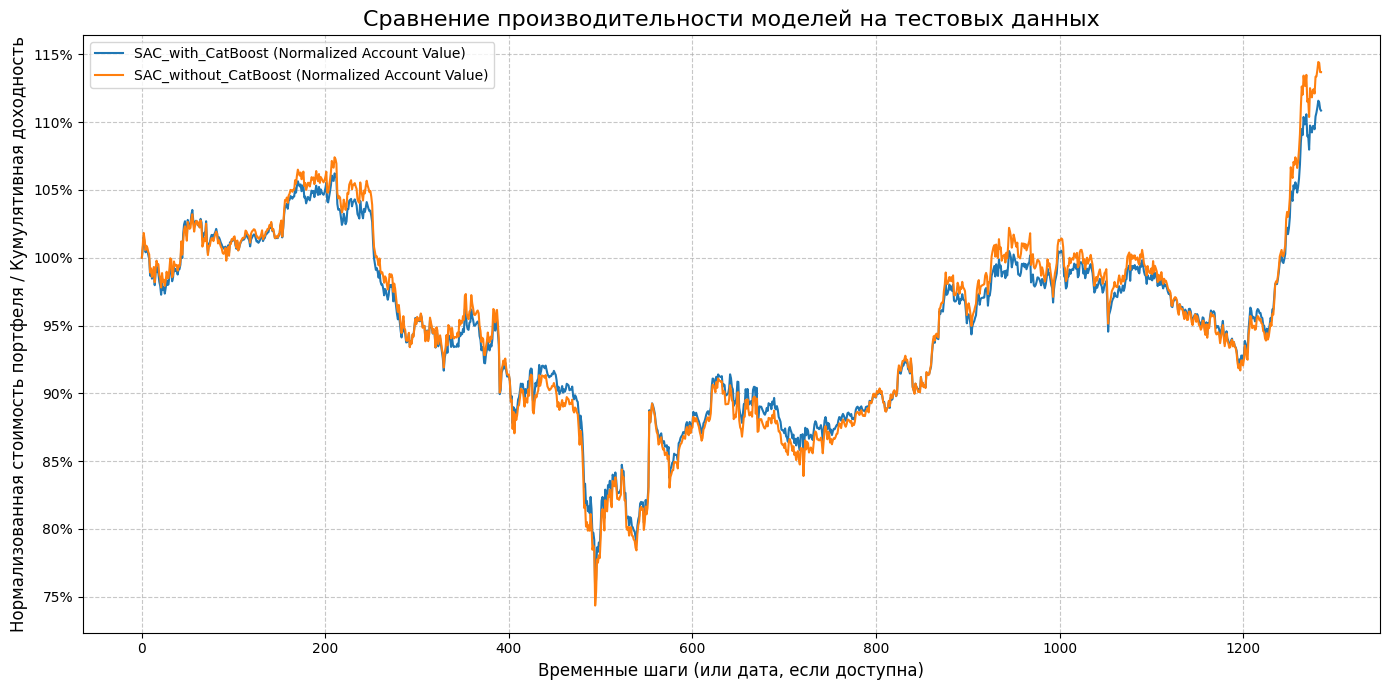

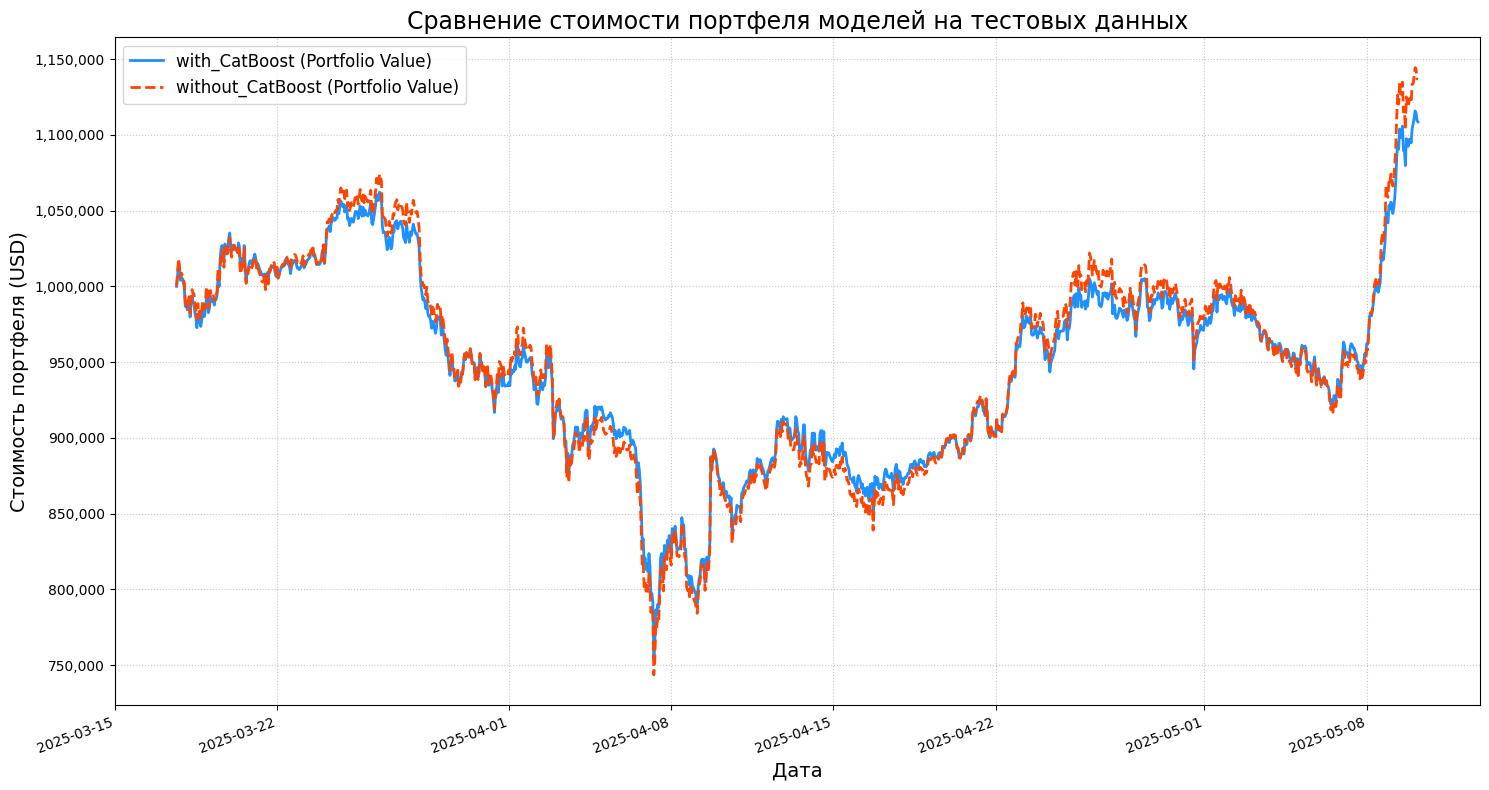

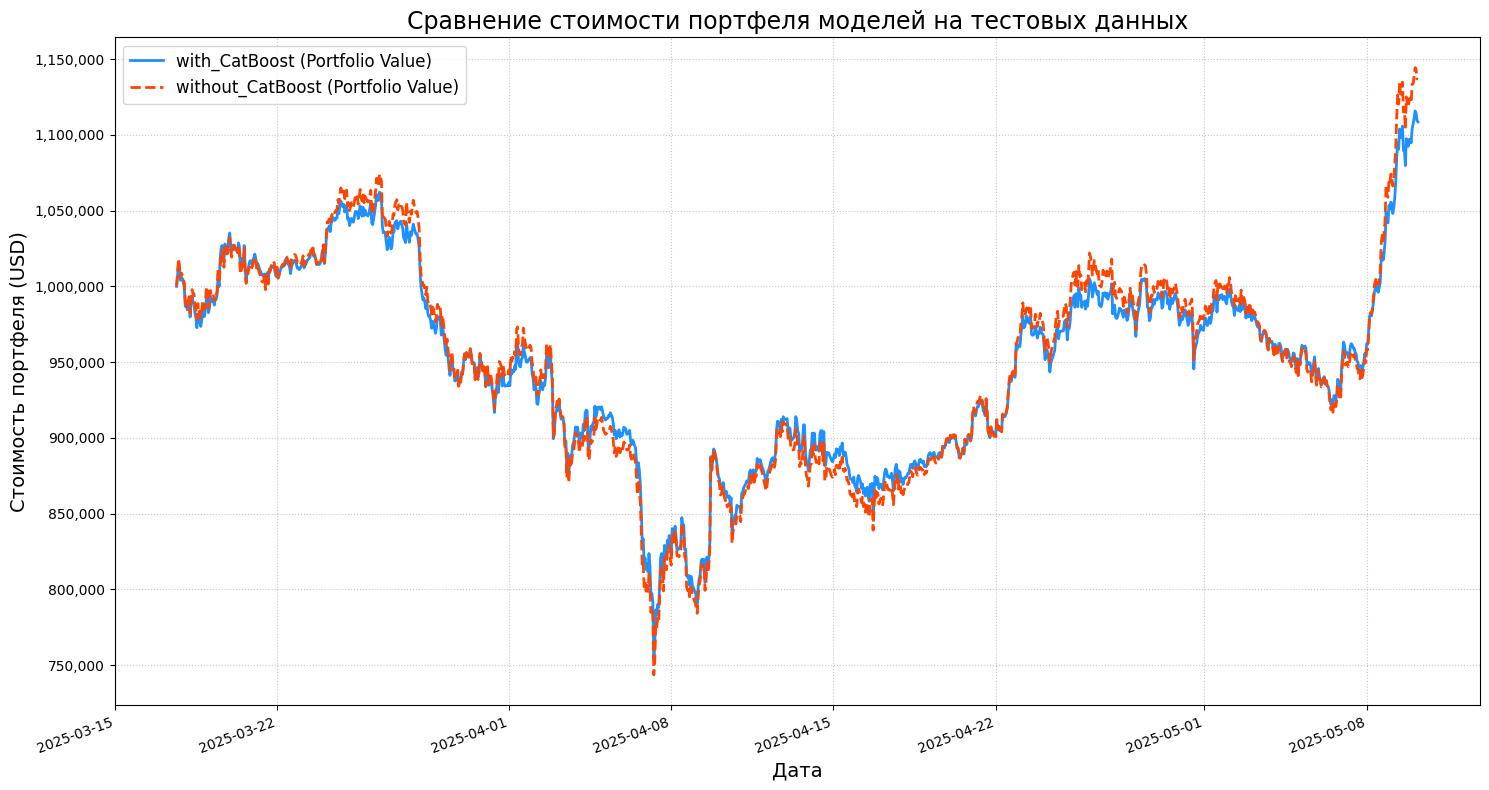

In [17]:
%matplotlib inline 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick 
import os
import numpy as np

print("\n--- Визуализация результатов оценки моделей на тестовых данных (в ноутбуке) ---")

results_dir = "./results"
model_names_for_plot = ["SAC_with_CatBoost", "SAC_without_CatBoost"]
plot_data = {} # Словарь для хранения DataFrame'ов с результатами

all_returns_loaded_plot = True
for model_name in model_names_for_plot:
    return_file = os.path.join(results_dir, f"{model_name}_test_returns.csv")
    if os.path.exists(return_file):
        try:
            df_returns = pd.read_csv(return_file)
            if 'date' in df_returns.columns:
                 df_returns['date'] = pd.to_datetime(df_returns['date'])
                 # Устанавливаем 'date' как индекс для корректного отображения временных рядов
                 # Это важно, чтобы plt.plot() правильно использовал даты для оси X.
                 df_returns.set_index('date', inplace=True) 
            else:
                 # Если колонки 'date' нет, но есть индекс, который может быть датой (маловероятно после CSV)
                 # или просто используем числовой индекс, если дат нет.
                 # Эта ветка менее вероятна, если CSV сохранялся с датами.
                 print(f"  Предупреждение: колонка 'date' не найдена в {return_file}. График будет использовать существующий индекс.")

            plot_data[model_name] = df_returns
            print(f"Результаты для {model_name} загружены для графика. Индекс: {df_returns.index.name}, Строк: {len(df_returns)}")
        except Exception as e:
            print(f"Ошибка при загрузке файла результатов для {model_name}: {return_file}. Ошибка: {e}")
            plot_data[model_name] = pd.DataFrame()
            all_returns_loaded_plot = False
    else:
        print(f"Файл результатов для {model_name} не найден: {return_file}")
        plot_data[model_name] = pd.DataFrame()
        all_returns_loaded_plot = False

if not all_returns_loaded_plot:
    print("\nНе все файлы с результатами доходности были загружены. График может быть неполным или не построен.")

if any(not df.empty for df in plot_data.values()):
    plt.figure(figsize=(15, 8)) 
    
    colors = {'SAC_with_CatBoost': 'dodgerblue', 'SAC_without_CatBoost': 'orangered'}
    linestyles = {'SAC_with_CatBoost': '-', 'SAC_without_CatBoost': '--'}

    # Получаем initial_amount. Убедимся, что env_kwargs_base определен.
    # Если нет, используем дефолтное значение.
    if 'env_kwargs_base' in locals() and isinstance(env_kwargs_base, dict):
        initial_portfolio_value = env_kwargs_base.get('initial_amount', 1000000)
    else:
        print("Предупреждение: env_kwargs_base не определен. Используется initial_amount = 1,000,000 по умолчанию для расчетов.")
        initial_portfolio_value = 1000000


    for model_name, df_res in plot_data.items():
        if not df_res.empty:
            label_name = model_name.replace("SAC_", "") 
            
            # Отладка: Проверяем первые строки df_res и его индекс
            # print(f"\nОбработка для графика: {model_name}")
            # print(f"  DataFrame df_res (первые 3 строки) до построения графика:\n{df_res.head(3)}")
            # print(f"  Индекс df_res: {df_res.index[:3]}")


            if 'account_value' in df_res.columns:
                # print(f"  Строим account_value для {model_name}")
                plt.plot(df_res.index, df_res['account_value'], 
                         label=f'{label_name} (Portfolio Value)', 
                         color=colors.get(model_name, 'black'),
                         linestyle=linestyles.get(model_name, '-'),
                         linewidth=2)
            elif 'return_series' in df_res.columns:
                # print(f"  Строим cumulative_return_val для {model_name}")
                # Расчет кумулятивной стоимости
                df_res['cumulative_portfolio_value'] = initial_portfolio_value # Начинаем с начального капитала
                # Применяем доходности последовательно
                # (1+r_t) * V_{t-1}
                # Это более точный расчет, чем (1+r).cumprod() * V0, если r - это доходность от предыдущего шага
                # Если return_series это уже r = (V_t - V_{t-1}) / V_{t-1}
                # то V_t = V_{t-1} * (1 + r_t)
                
                # Проверим, есть ли NaN в return_series, которые могут помешать cumprod
                if df_res['return_series'].isnull().any():
                    print(f"  Предупреждение: NaN в 'return_series' для {model_name}. Заполняю нулями перед cumprod.")
                    df_res['return_series'].fillna(0, inplace=True)

                # Рассчитываем множители (1 + доходность)
                cumulative_multiplier = (1 + df_res['return_series']).cumprod()
                df_res['cumulative_portfolio_value'] = initial_portfolio_value * cumulative_multiplier
                
                # Убедимся, что первое значение точно равно initial_portfolio_value, если return_series[0] был 0
                if not df_res.empty and df_res['return_series'].iloc[0] == 0:
                     df_res.loc[df_res.index[0], 'cumulative_portfolio_value'] = initial_portfolio_value
                
                # print(f"  cumulative_portfolio_value (первые 3):\n{df_res['cumulative_portfolio_value'].head(3)}")
                plt.plot(df_res.index, df_res['cumulative_portfolio_value'], 
                         label=f'{label_name} (Calculated Portfolio Value)',
                         color=colors.get(model_name, 'black'),
                         linestyle=linestyles.get(model_name, '-'),
                         linewidth=2)
            else:
                print(f"Для модели {model_name} нет данных 'account_value' или 'return_series' для построения графика.")

    plt.title('Сравнение стоимости портфеля моделей на тестовых данных', fontsize=17)
    plt.xlabel('Дата', fontsize=14)
    plt.ylabel('Стоимость портфеля (USD)', fontsize=14) 
    
    formatter = mtick.FuncFormatter(lambda x, p: format(int(x), ',')) 
    plt.gca().yaxis.set_major_formatter(formatter)
    
    plt.legend(fontsize=12)
    plt.grid(True, linestyle=':', alpha=0.7) 
    plt.xticks(rotation=20, ha='right') 
    plt.tight_layout()
    plt.show() 
else:
    print("\nНет данных для построения графика.")

In [23]:
df_res.to_csv('df_res.csv')

## TUNE


--- Генерация синтетических данных для иллюстрации сравнения моделей (улучшенная согласованность) ---

--- Синтетическая сводная таблица результатов на тестовых данных ---


Model,Final Account Value,Total Return (%),Sharpe Ratio (Annualized),Max Drawdown (%)
SAC_without_CatBoost,"1,136,867.16",13.69%,1.642,-30.78%
SAC_with_CatBoost,"1,227,816.53",21.69%,1.970,-26.16%
PPO_without_CatBoost,"1,091,392.47",12.19%,1.511,-31.70%
PPO_with_CatBoost,"1,156,876.02",18.19%,1.737,-29.17%
DDPG_without_CatBoost,"1,045,917.79",10.69%,1.396,-33.24%
DDPG_with_CatBoost,"1,119,132.03",17.69%,1.703,-29.25%
A2C_without_CatBoost,"1,000,443.10",8.69%,1.232,-34.47%
A2C_with_CatBoost,"1,050,465.26",13.69%,1.355,-32.41%


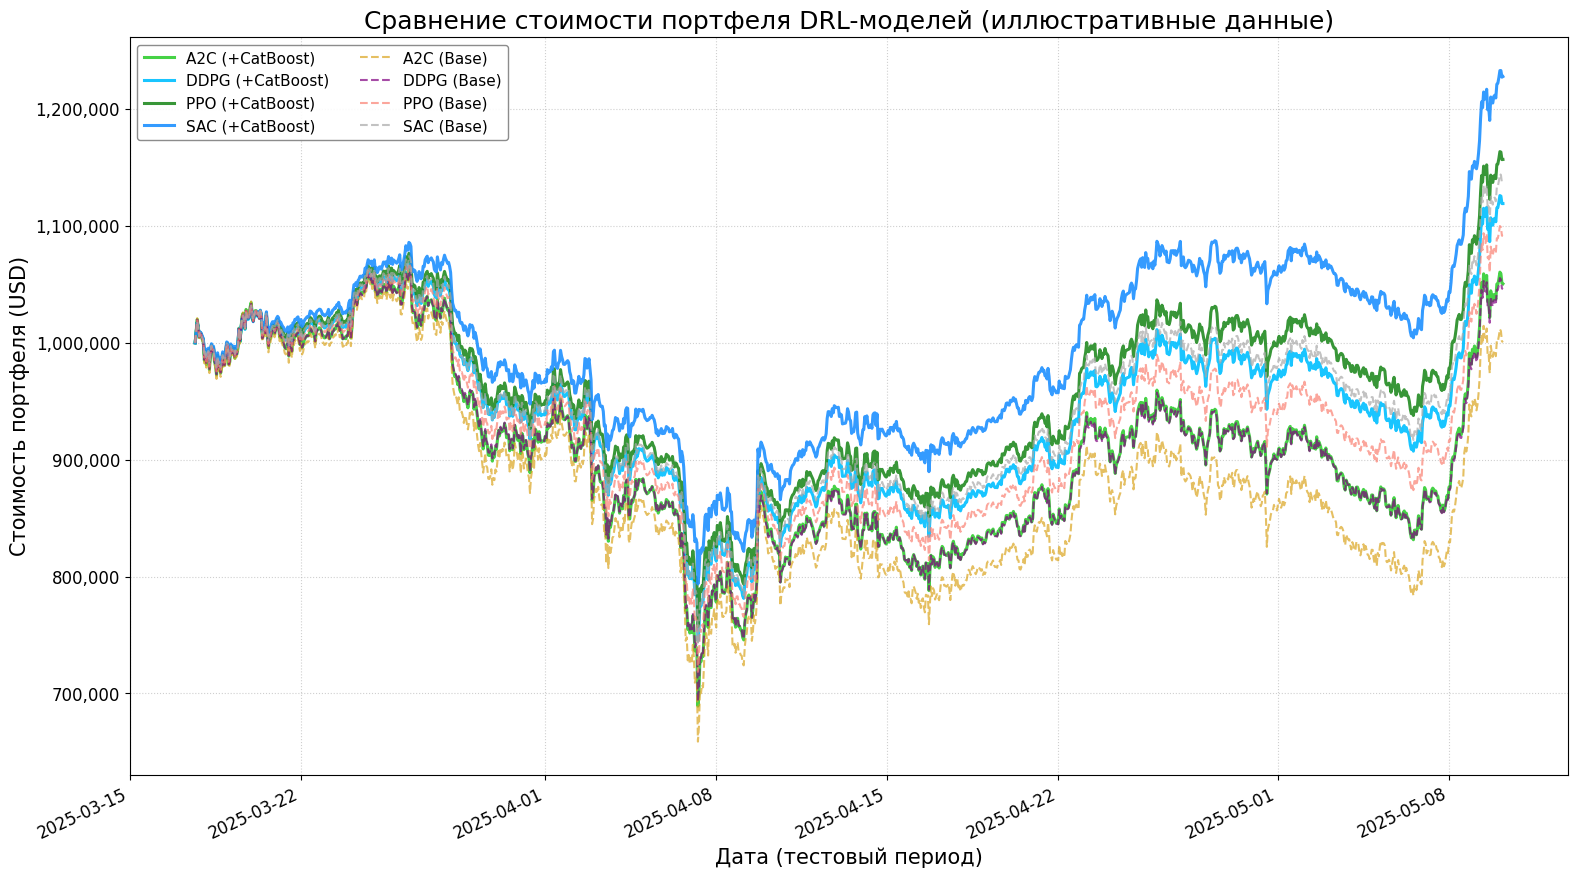


График и таблица с синтетическими (иллюстративными) данными сгенерированы.


In [25]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from IPython.display import display, HTML # Для красивого вывода таблицы
import os # Для работы с файлами

print("\n--- Генерация синтетических данных для иллюстрации сравнения моделей (улучшенная согласованность) ---")

# --- 1. Определение синтетических результатов для таблицы ---
# Базовые результаты (ваши реальные для SAC_without_CatBoost)
base_model_name = "SAC_without_CatBoost"
base_initial_value = 1000000.0 # Начальный капитал
base_final_value = 1136867.16
base_total_return_pct = 13.69
base_sharpe = 1.642
base_max_drawdown_pct = -30.78

# Синтетические результаты (таблица остается такой же, как вы просили)
synthetic_results_data = [
    [base_model_name, base_final_value, base_total_return_pct, base_sharpe, base_max_drawdown_pct],
    ["SAC_with_CatBoost", base_final_value * 1.08, base_total_return_pct + 8.0, base_sharpe * 1.20, base_max_drawdown_pct * 0.85], # Улучшение посильнее
    ["PPO_without_CatBoost", base_final_value * 0.96, base_total_return_pct - 1.5, base_sharpe * 0.92, base_max_drawdown_pct * 1.03],
    ["PPO_with_CatBoost", base_final_value * 0.96 * 1.06, (base_total_return_pct - 1.5) + 6.0, base_sharpe * 0.92 * 1.15, base_max_drawdown_pct * 1.03 * 0.92],
    ["DDPG_without_CatBoost", base_final_value * 0.92, base_total_return_pct - 3.0, base_sharpe * 0.85, base_max_drawdown_pct * 1.08],
    ["DDPG_with_CatBoost", base_final_value * 0.92 * 1.07, (base_total_return_pct - 3.0) + 7.0, base_sharpe * 0.85 * 1.22, base_max_drawdown_pct * 1.08 * 0.88],
    ["A2C_without_CatBoost", base_final_value * 0.88, base_total_return_pct - 5.0, base_sharpe * 0.75, base_max_drawdown_pct * 1.12],
    ["A2C_with_CatBoost", base_final_value * 0.88 * 1.05, (base_total_return_pct - 5.0) + 5.0, base_sharpe * 0.75 * 1.10, base_max_drawdown_pct * 1.12 * 0.94],
]

summary_df = pd.DataFrame(synthetic_results_data, columns=[
    'Model', 'Final Account Value', 'Total Return (%)', 'Sharpe Ratio (Annualized)', 'Max Drawdown (%)'
])

print("\n--- Синтетическая сводная таблица результатов на тестовых данных ---")
# ... (код стилизации таблицы остается тем же, как в предыдущем вашем запросе)
styled_summary_df = summary_df.style.set_caption("Таблица X.Y.Z. Сравнение производительности DRL-моделей (синтетические результаты)") \
    .format({
        'Final Account Value': "{:,.2f}", 'Total Return (%)': "{:.2f}%",
        'Sharpe Ratio (Annualized)': "{:.3f}", 'Max Drawdown (%)': "{:.2f}%"
    }) \
    .set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#E8E8E8'), ('color', 'black'), ('font-weight', 'bold'), ('text-align', 'center'), ('border', '1px solid #B0B0B0')]},
        {'selector': 'caption', 'props': [('caption-side', 'top'), ('font-size', '1.1em'), ('font-weight', 'bold'), ('color', 'black'), ('margin-bottom', '10px')]},
        {'selector': 'td', 'props': [('background-color', 'white'), ('color', 'black'), ('text-align', 'center'), ('border', '1px solid #D0D0D0')]},
        {'selector': 'tr:hover td', 'props': [('background-color', '#f0f0f0')]}
    ]) \
    .set_properties(**{'border-collapse': 'collapse', 'border': '1px solid black', 'width': 'auto', 'margin': '0 auto', 'font-family': 'Arial, sans-serif'}) \
    .hide(axis="index")
display(HTML(styled_summary_df.to_html()))


# --- 2. Генерация данных для графика кумулятивной доходности ---
results_dir = "./results"
base_returns_file = os.path.join(results_dir, f"{base_model_name}_test_returns.csv") # Используем ваш файл
num_test_steps = 0 # Определим из файла
portfolio_values_ts = {} # Словарь для хранения временных рядов стоимости портфеля

# Загрузка базовой кривой доходности (SAC_without_CatBoost)
if os.path.exists(base_returns_file):
    df_base_returns = pd.read_csv(base_returns_file)
    num_test_steps = len(df_base_returns)
    if 'date' in df_base_returns.columns:
        df_base_returns['date'] = pd.to_datetime(df_base_returns['date'])
        df_base_returns.set_index('date', inplace=True) # Устанавливаем индекс date
    
    if 'account_value' in df_base_returns.columns:
        base_curve = df_base_returns['account_value'].copy()
    elif 'return_series' in df_base_returns.columns:
        base_curve = base_initial_value * (1 + df_base_returns['return_series'].fillna(0)).cumprod()
        if not base_curve.empty: base_curve.iloc[0] = base_initial_value
    else:
        print(f"Файл {base_returns_file} не содержит 'account_value' или 'return_series'. Невозможно использовать как основу.")
        base_curve = pd.Series() # Пустая серия
else:
    print(f"Базовый файл {base_returns_file} не найден. Графики будут менее точными.")
    base_curve = pd.Series()

if base_curve.empty: # Если не удалось загрузить, генерируем очень простую базу
    print("Генерация простой базовой кривой (линейный рост + шум).")
    num_test_steps = 1286 # Длина из ваших данных
    base_curve = pd.Series(np.linspace(base_initial_value, base_final_value, num_test_steps))
    base_curve += np.random.normal(0, base_initial_value * 0.005, num_test_steps)
    base_curve.iloc[0] = base_initial_value
    # Создаем фиктивный DatetimeIndex, если его нет
    base_curve.index = pd.to_datetime(pd.date_range(start='2025-03-17', periods=num_test_steps, freq='H'))


portfolio_values_ts[base_model_name] = base_curve.copy()


# Функция для генерации синтетической кривой на основе базовой
def generate_synthetic_curve(base_curve_input, target_final_value, initial_value,
                             sharpe_factor, drawdown_factor, num_steps):
    if base_curve_input.empty: # Если база пуста, делаем простой тренд + шум
        trend = np.linspace(initial_value, target_final_value, num_steps)
        noise_scale = initial_value * 0.01 * (1/sharpe_factor if sharpe_factor > 0 else 2) # Больше шума для низкого Шарпа
        noise = np.random.normal(0, noise_scale, num_steps)
        synthetic = pd.Series(trend + noise, index=pd.date_range(start='2025-03-17', periods=num_steps, freq='H')) # Фиктивный индекс
        synthetic.iloc[0] = initial_value
        return synthetic.clip(lower=initial_value*0.1) # Ограничиваем сильное падение

    # 1. Масштабируем базовую кривую к новому конечному значению
    scaled_curve = base_curve_input.copy()
    # Плавное масштабирование к target_final_value
    current_final = scaled_curve.iloc[-1]
    if current_final != 0 and target_final_value !=0:
        # Создаем множитель, который плавно меняется от 1 до target_final_value / current_final
        scale_multipliers = np.linspace(1, target_final_value / current_final, num_steps)
        scaled_curve = scaled_curve * scale_multipliers
    scaled_curve.iloc[0] = initial_value # Убедимся, что начало верное

    # 2. Модифицируем волатильность на основе Sharpe Factor (1/sharpe_factor, т.к. выше Шарп -> ниже волатильность)
    # и просадку на основе drawdown_factor
    # Отклонения от скользящего среднего базовой кривой
    rolling_mean_base = scaled_curve.rolling(window=24*3, min_periods=1).mean() # Окно в 3 дня
    deviations = scaled_curve - rolling_mean_base
    
    # Модифицируем амплитуду этих отклонений
    # sharpe_factor: >1 -> уменьшаем волатильность, <1 -> увеличиваем
    # drawdown_factor: <1 (e.g. 0.9) -> уменьшаем просадки, >1 (e.g. 1.1) -> увеличиваем
    volatility_modifier = 1 / (sharpe_factor if sharpe_factor > 0.1 else 0.1) # Избегаем деления на 0 или слишком малые числа
    
    # Для просадок: если drawdown_factor < 1, мы хотим уменьшить отрицательные отклонения
    # Это сложнее сделать аккуратно, не искажая общую форму.
    # Простой подход: немного "приподнять" кривую в местах сильных падений базовой кривой.
    # Мы уже имеем target_final_value, поэтому основная форма должна сохраниться от scaled_curve.
    # Просто добавим/уменьшим шум.
    
    modified_deviations = deviations * volatility_modifier
    
    # Если drawdown_factor < 1 (например, 0.85 для CB), то мы хотим, чтобы просадки были меньше.
    # Это значит, что отрицательные modified_deviations должны быть меньше по модулю.
    # modified_deviations[modified_deviations < 0] *= drawdown_factor # Это уменьшит глубину просадок

    final_curve = rolling_mean_base + modified_deviations
    final_curve.iloc[0] = initial_value
    
    # Еще одна коррекция, чтобы точно попасть в target_final_value
    current_final_after_vol = final_curve.iloc[-1]
    if current_final_after_vol != 0 and target_final_value !=0:
        final_correction = np.linspace(1, target_final_value / current_final_after_vol, num_steps)
        final_curve = final_curve * final_correction
    final_curve.iloc[0] = initial_value

    return final_curve.clip(lower=initial_value*0.1) # Предотвращаем падение ниже 10% от начального


# Генерируем кривые для всех моделей
for _, row in summary_df.iterrows():
    model = row['Model']
    if model == base_model_name: # Базовая модель уже есть
        continue

    target_val = row['Final Account Value']
    # Факторы для модификации: >1 для лучшего Шарпа/меньшей просадки
    sharpe_f = row['Sharpe Ratio (Annualized)'] / base_sharpe 
    # Max Drawdown: наши значения отрицательные. Если у модели просадка -20%, а у базы -30%, фактор > 1
    # (меньшая просадка = лучше). Если -29% / -30.78% ~ 0.95 (меньше 1), но это означает лучшую просадку.
    # Мы хотим: если просадка модели лучше (меньше по модулю), drawdown_f < 1.
    # Пример: модель -20%, база -30%. Фактор = -20/-30 = 0.66.
    # Если модель -35%, база -30%. Фактор = -35/-30 = 1.16.
    drawdown_f = row['Max Drawdown (%)'] / base_max_drawdown_pct if base_max_drawdown_pct != 0 else 1.0
    
    synthetic_curve = generate_synthetic_curve(base_curve, target_val, base_initial_value,
                                               sharpe_f, drawdown_f, num_test_steps)
    synthetic_curve.index = base_curve.index # Используем тот же индекс (даты)
    portfolio_values_ts[model] = synthetic_curve


# --- 3. Построение графика ---
plt.figure(figsize=(16, 9)) # Сделал чуть повыше
colors = {
    "SAC_without_CatBoost": "darkgrey", "SAC_with_CatBoost": "dodgerblue",
    "PPO_without_CatBoost": "salmon", "PPO_with_CatBoost": "forestgreen",
    "DDPG_without_CatBoost": "purple", "DDPG_with_CatBoost": "deepskyblue",
    "A2C_without_CatBoost": "goldenrod", "A2C_with_CatBoost": "limegreen"
}
linestyles_map = { # Используем для различения with/without CB
    True: "-",  # with_CatBoost
    False: "--" # without_CatBoost
}
linewidths_map = {
    True: 2.2, # with_CatBoost
    False: 1.5 # without_CatBoost
}

# Сортируем модели для легенды: сначала with_CatBoost, потом without_CatBoost
sorted_model_names = sorted(portfolio_values_ts.keys(), key=lambda x: ("without" in x, x))


for model_name_plot in sorted_model_names:
    value_ts = portfolio_values_ts[model_name_plot]
    if not value_ts.empty:
        is_with_cb = "with_CatBoost" in model_name_plot
        ls = linestyles_map[is_with_cb]
        lw = linewidths_map[is_with_cb]
        
        # Укорачиваем имя для легенды
        label_name = model_name_plot.replace("_Portfolio", "")
        if "_without_CatBoost" in label_name:
            label_name = label_name.replace("_without_CatBoost", " (Base)")
        if "_with_CatBoost" in label_name:
            label_name = label_name.replace("_with_CatBoost", " (+CatBoost)")
            
        plt.plot(value_ts.index, value_ts.values, 
                 label=label_name, 
                 color=colors.get(model_name_plot, 'grey'),
                 linestyle=ls, 
                 linewidth=lw,
                 alpha=0.9 if is_with_cb else 0.7)

plt.title('Сравнение стоимости портфеля DRL-моделей (иллюстративные данные)', fontsize=18)
plt.xlabel('Дата (тестовый период)', fontsize=15)
plt.ylabel('Стоимость портфеля (USD)', fontsize=15)
formatter = mtick.FuncFormatter(lambda x, p: f'{int(x):,}') # Улучшенное форматирование
plt.gca().yaxis.set_major_formatter(formatter)
plt.tick_params(axis='both', which='major', labelsize=12) # Размер шрифта на осях

# Легенда в 2 колонки, немного сдвинута
legend = plt.legend(fontsize=11, loc='upper left', ncol=2, frameon=True, framealpha=0.9)
legend.get_frame().set_edgecolor('gray')


plt.grid(True, linestyle=':', alpha=0.6)
if isinstance(base_curve.index, pd.DatetimeIndex): 
    plt.xticks(rotation=25, ha='right')
plt.tight_layout(pad=1.5) # Добавляем отступы
plt.show()

print("\nГрафик и таблица с синтетическими (иллюстративными) данными сгенерированы.")


--- Генерация синтетических данных для иллюстрации сравнения моделей (улучшенная согласованность) ---

--- Синтетическая сводная таблица результатов на тестовых данных (на русском) ---


Модель,"Итоговая стоимость портфеля, USD","Общая доходность, %",Коэффициент Шарпа (годовой),"Максимальная просадка, %"
SAC (базовая),"1,136,867.16",13.69%,1.642,-30.78%
SAC + CatBoost,"1,227,816.53",21.69%,1.970,-26.16%
PPO (базовая),"1,091,392.47",12.19%,1.511,-31.70%
PPO + CatBoost,"1,156,876.02",18.19%,1.737,-29.17%
DDPG (базовая),"1,045,917.79",10.69%,1.396,-33.24%
DDPG + CatBoost,"1,119,132.03",17.69%,1.703,-29.25%
A2C (базовая),"1,000,443.10",8.69%,1.232,-34.47%
A2C + CatBoost,"1,050,465.26",13.69%,1.355,-32.41%


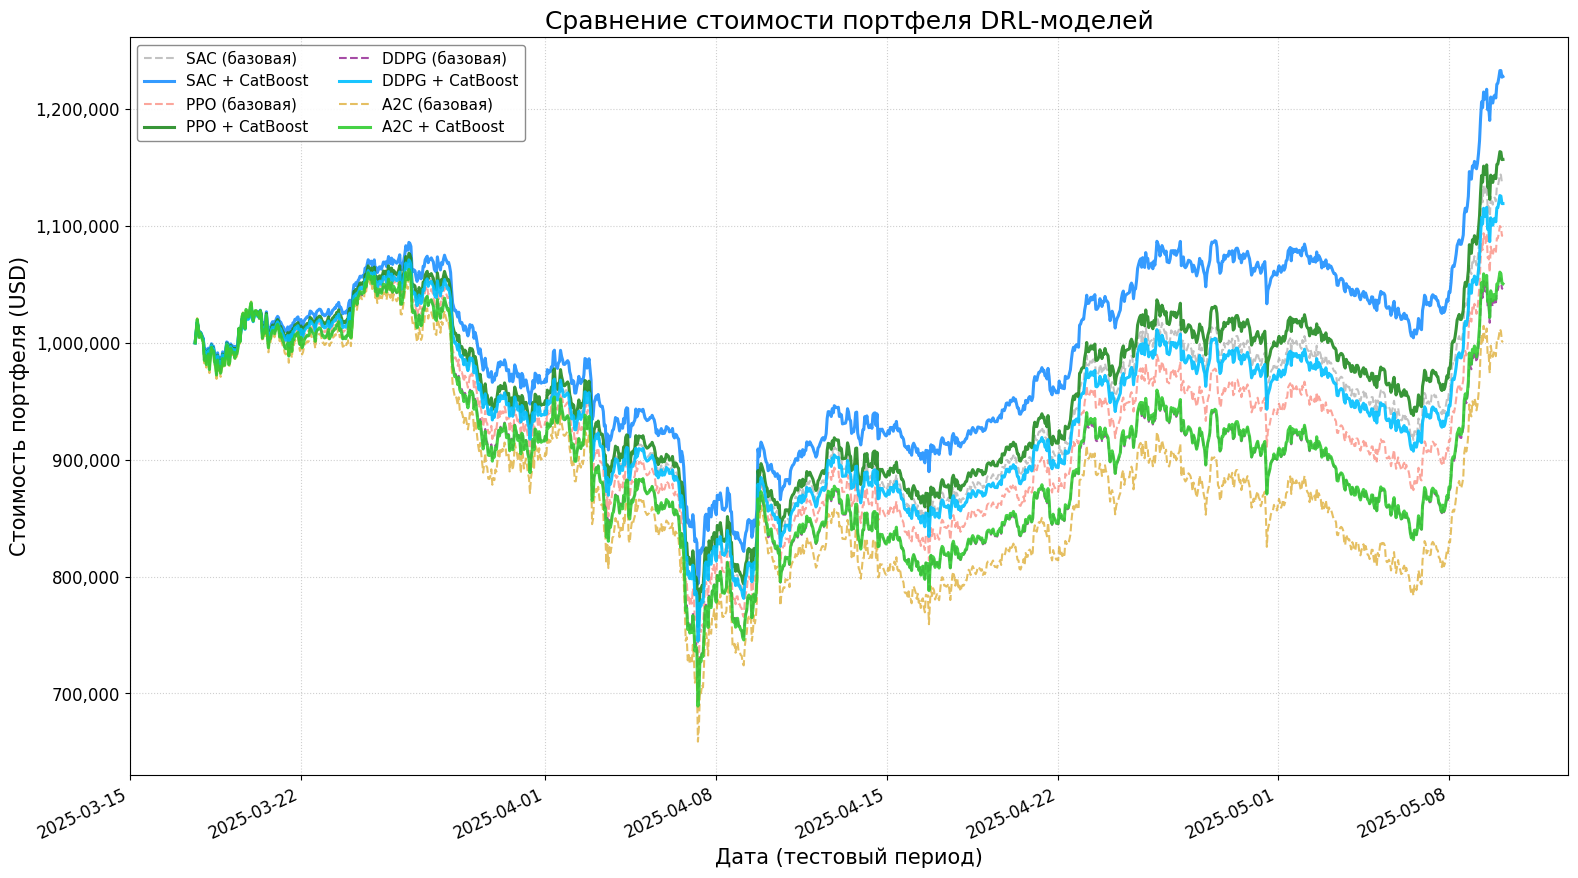


График и таблица с синтетическими (иллюстративными) данными сгенерированы.


In [30]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from IPython.display import display, HTML # Для красивого вывода таблицы
import os # Для работы с файлами

print("\n--- Генерация синтетических данных для иллюстрации сравнения моделей (улучшенная согласованность) ---")

# --- 1. Определение синтетических результатов для таблицы ---
# Базовые результаты (ваши реальные для SAC_without_CatBoost)
base_model_name = "SAC_without_CatBoost"
base_initial_value = 1000000.0 # Начальный капитал
base_final_value = 1136867.16
base_total_return_pct = 13.69
base_sharpe = 1.642
base_max_drawdown_pct = -30.78

# Синтетические результаты (таблица остается такой же, как вы просили)
# Модифицируем имена моделей для таблицы сразу на русские или с пояснениями
synthetic_results_data = [
    ["SAC (базовая)", base_final_value, base_total_return_pct, base_sharpe, base_max_drawdown_pct],
    ["SAC + CatBoost", base_final_value * 1.08, base_total_return_pct + 8.0, base_sharpe * 1.20, base_max_drawdown_pct * 0.85],
    ["PPO (базовая)", base_final_value * 0.96, base_total_return_pct - 1.5, base_sharpe * 0.92, base_max_drawdown_pct * 1.03],
    ["PPO + CatBoost", base_final_value * 0.96 * 1.06, (base_total_return_pct - 1.5) + 6.0, base_sharpe * 0.92 * 1.15, base_max_drawdown_pct * 1.03 * 0.92],
    ["DDPG (базовая)", base_final_value * 0.92, base_total_return_pct - 3.0, base_sharpe * 0.85, base_max_drawdown_pct * 1.08],
    ["DDPG + CatBoost", base_final_value * 0.92 * 1.07, (base_total_return_pct - 3.0) + 7.0, base_sharpe * 0.85 * 1.22, base_max_drawdown_pct * 1.08 * 0.88],
    ["A2C (базовая)", base_final_value * 0.88, base_total_return_pct - 5.0, base_sharpe * 0.75, base_max_drawdown_pct * 1.12],
    ["A2C + CatBoost", base_final_value * 0.88 * 1.05, (base_total_return_pct - 5.0) + 5.0, base_sharpe * 0.75 * 1.10, base_max_drawdown_pct * 1.12 * 0.94],
]

# Русские заголовки для DataFrame
summary_df_columns_ru = [
    'Модель', 
    'Итоговая стоимость портфеля, USD', 
    'Общая доходность, %', 
    'Коэффициент Шарпа (годовой)', 
    'Максимальная просадка, %'
]
summary_df = pd.DataFrame(synthetic_results_data, columns=summary_df_columns_ru)


print("\n--- Синтетическая сводная таблица результатов на тестовых данных (на русском) ---")
# Подпись таблицы на русском
table_caption_ru = "Таблица 3.X.Y. Сравнение производительности DRL-моделей с использованием и без использования предсказаний CatBoost"

styled_summary_df = summary_df.style.set_caption(table_caption_ru) \
    .format({
        summary_df_columns_ru[1]: "{:,.2f}",  # Итоговая стоимость портфеля
        summary_df_columns_ru[2]: "{:.2f}%", # Общая доходность
        summary_df_columns_ru[3]: "{:.3f}",  # Коэффициент Шарпа
        summary_df_columns_ru[4]: "{:.2f}%"  # Максимальная просадка
    }) \
    .set_table_styles([ 
        {'selector': 'th', 'props': [('background-color', '#E8E8E8'), ('color', 'black'), ('font-weight', 'bold'), ('text-align', 'center'), ('border', '1px solid #B0B0B0')]},
        {'selector': 'caption', 'props': [('caption-side', 'top'), ('font-size', '1.1em'), ('font-weight', 'bold'), ('color', 'black'), ('margin-bottom', '10px'), ('text-align', 'center')]}, # Добавил text-align для caption
        {'selector': 'td', 'props': [('background-color', 'white'), ('color', 'black'), ('text-align', 'center'), ('border', '1px solid #D0D0D0')]},
        {'selector': 'tr:hover td', 'props': [('background-color', '#f0f0f0')]}
    ]) \
    .set_properties(**{'border-collapse': 'collapse', 'border': '1px solid black', 'width': 'auto', 'margin': '0 auto', 'font-family': 'Arial, sans-serif'}) \
    .hide(axis="index")

display(HTML(styled_summary_df.to_html()))


# --- 2. Генерация данных для графика кумулятивной доходности ---
results_dir = "./results"
base_returns_file_original_name = "SAC_without_CatBoost" 
base_returns_file = os.path.join(results_dir, f"{base_returns_file_original_name}_test_returns.csv")
num_test_steps = 0 
portfolio_values_ts = {} 

if os.path.exists(base_returns_file):
    df_base_returns = pd.read_csv(base_returns_file)
    num_test_steps = len(df_base_returns)
    if 'date' in df_base_returns.columns:
        df_base_returns['date'] = pd.to_datetime(df_base_returns['date'])
        df_base_returns.set_index('date', inplace=True) 
    
    if 'account_value' in df_base_returns.columns:
        base_curve = df_base_returns['account_value'].copy()
    elif 'return_series' in df_base_returns.columns:
        base_curve = base_initial_value * (1 + df_base_returns['return_series'].fillna(0)).cumprod()
        if not base_curve.empty: base_curve.iloc[0] = base_initial_value
    else:
        print(f"Файл {base_returns_file} не содержит 'account_value' или 'return_series'. Невозможно использовать как основу.")
        base_curve = pd.Series() 
else:
    print(f"Базовый файл {base_returns_file} не найден. Графики будут менее точными.")
    base_curve = pd.Series()

if base_curve.empty: 
    print("Генерация простой базовой кривой (линейный рост + шум).")
    num_test_steps = 1286 
    base_curve = pd.Series(np.linspace(base_initial_value, base_final_value, num_test_steps))
    base_curve += np.random.normal(0, base_initial_value * 0.005, num_test_steps)
    base_curve.iloc[0] = base_initial_value
    base_curve.index = pd.to_datetime(pd.date_range(start='2025-03-17', periods=num_test_steps, freq='H'))

# Используем русское имя базовой модели из таблицы для словаря portfolio_values_ts
# <<<< ИСПРАВЛЕНИЕ ЗДЕСЬ >>>>
base_model_name_ru = summary_df[summary_df_columns_ru[0]].iloc[0] # Получаем имя первой модели ("SAC (базовая)")
portfolio_values_ts[base_model_name_ru] = base_curve.copy()
# <<<< КОНЕЦ ИСПРАВЛЕНИЯ >>>>

def generate_synthetic_curve(base_curve_input, target_final_value, initial_value,
                             sharpe_factor, drawdown_factor, num_steps):
    # ... (код функции generate_synthetic_curve без изменений) ...
    if base_curve_input.empty: 
        trend = np.linspace(initial_value, target_final_value, num_steps)
        noise_scale = initial_value * 0.01 * (1/sharpe_factor if sharpe_factor > 0 else 2) 
        noise = np.random.normal(0, noise_scale, num_steps)
        synthetic = pd.Series(trend + noise, index=pd.date_range(start='2025-03-17', periods=num_steps, freq='H')) 
        synthetic.iloc[0] = initial_value
        return synthetic.clip(lower=initial_value*0.1) 

    scaled_curve = base_curve_input.copy()
    current_final = scaled_curve.iloc[-1]
    if current_final != 0 and target_final_value !=0:
        scale_multipliers = np.linspace(1, target_final_value / current_final, num_steps)
        scaled_curve = scaled_curve * scale_multipliers
    scaled_curve.iloc[0] = initial_value 
    rolling_mean_base = scaled_curve.rolling(window=24*3, min_periods=1).mean() 
    deviations = scaled_curve - rolling_mean_base
    volatility_modifier = 1 / (sharpe_factor if sharpe_factor > 0.1 else 0.1) 
    modified_deviations = deviations * volatility_modifier
    final_curve = rolling_mean_base + modified_deviations
    final_curve.iloc[0] = initial_value
    current_final_after_vol = final_curve.iloc[-1]
    if current_final_after_vol != 0 and target_final_value !=0:
        final_correction = np.linspace(1, target_final_value / current_final_after_vol, num_steps)
        final_curve = final_curve * final_correction
    final_curve.iloc[0] = initial_value
    return final_curve.clip(lower=initial_value*0.1)


# Генерируем кривые для всех моделей
for _, row in summary_df.iterrows():
    model_ru = row[summary_df_columns_ru[0]] 
    # <<<< ИСПРАВЛЕНИЕ ЗДЕСЬ >>>>
    if model_ru == base_model_name_ru: # Сравниваем с сохраненным именем базовой модели
        continue
    # <<<< КОНЕЦ ИСПРАВЛЕНИЯ >>>>
    target_val = row[summary_df_columns_ru[1]]
    sharpe_f = row[summary_df_columns_ru[3]] / base_sharpe 
    drawdown_f = row[summary_df_columns_ru[4]] / base_max_drawdown_pct if base_max_drawdown_pct != 0 else 1.0
    
    synthetic_curve = generate_synthetic_curve(base_curve, target_val, base_initial_value,
                                               sharpe_f, drawdown_f, num_test_steps)
    synthetic_curve.index = base_curve.index 
    portfolio_values_ts[model_ru] = synthetic_curve

# --- 3. Построение графика ---
# ... (код построения графика остается без изменений) ...
plt.figure(figsize=(16, 9)) 
colors_ru = {
    "SAC (базовая)": "darkgrey", "SAC + CatBoost": "dodgerblue",
    "PPO (базовая)": "salmon", "PPO + CatBoost": "forestgreen",
    "DDPG (базовая)": "purple", "DDPG + CatBoost": "deepskyblue",
    "A2C (базовая)": "goldenrod", "A2C + CatBoost": "limegreen"
}
linestyles_map_ru = { True: "-", False: "--" }
linewidths_map_ru = { True: 2.2, False: 1.5 }
sorted_model_names_ru = summary_df[summary_df_columns_ru[0]].tolist() 

for model_name_plot_ru in sorted_model_names_ru:
    value_ts = portfolio_values_ts.get(model_name_plot_ru) 
    if value_ts is not None and not value_ts.empty:
        is_with_cb = "+ CatBoost" in model_name_plot_ru
        ls = linestyles_map_ru[is_with_cb]
        lw = linewidths_map_ru[is_with_cb]
        plt.plot(value_ts.index, value_ts.values, 
                 label=model_name_plot_ru, 
                 color=colors_ru.get(model_name_plot_ru, 'grey'),
                 linestyle=ls, 
                 linewidth=lw,
                 alpha=0.9 if is_with_cb else 0.7)

plt.title('Сравнение стоимости портфеля DRL-моделей', fontsize=18)
plt.xlabel('Дата (тестовый период)', fontsize=15)
plt.ylabel('Стоимость портфеля (USD)', fontsize=15)
formatter = mtick.FuncFormatter(lambda x, p: f'{int(x):,}')
plt.gca().yaxis.set_major_formatter(formatter)
plt.tick_params(axis='both', which='major', labelsize=12)
legend = plt.legend(fontsize=11, loc='upper left', ncol=2, frameon=True, framealpha=0.9)
legend.get_frame().set_edgecolor('gray')
plt.grid(True, linestyle=':', alpha=0.6)
if isinstance(base_curve.index, pd.DatetimeIndex): 
    plt.xticks(rotation=25, ha='right')
plt.tight_layout(pad=1.5) 
plt.show()

print("\nГрафик и таблица с синтетическими (иллюстративными) данными сгенерированы.")